<table style="width: 100%; border-collapse: collapse;" border="0">
<tr>
<td><b>Created:</b> Tuesday 7 August 2018</td>
<td style="text-align: right;"><a href="https://github.com/douglask3/savanna_fire_feedback_test">github.com/douglask3/savanna_fire_feedback_test</td>
</tr>
</table>

<div>
<center>
<font face="Times">
<br>
<h1>Quantifying the uncertainity in climate potentials and mortality using Bayesian inference</h1>
<h2>Part 3: Posterior sampling</h2>
<br>
<br>
<sup>1,* </sup>Douglas Kelley, 
<sup>1 </sup>France Gerard, 
<sup>2 </sup>Rhys Whitley, 
<sup>3 </sup>Elmar Veenendaal
<br>
<br>
<br>
<sup>1 </sup>Centre for Ecology and Hydrology, Maclean Building, Crowmarsh Gifford, Wallingford, Oxfordshire, United Kingdom
<br>
<sup>2 </sup>Natural Perils Pricing, Commercial & Consumer Portfolio & Pricing, Suncorp Group, Sydney, Australia
<br>
<sup>3 </sup>Wageningen Univsersity, Wageningen UR
<br>
<br>
<h3>Summary</h3>
<hr>
<p> 
This notebook aims to quantify the model parameters of a global tree cover model model. Tree Cover is calculated as a product  precipitation, tempurature  and radiation controls describing large scale climate potetials, and mortality from fire, seasonal drought, tempuature and people, and exlusion from land use modulate tree cover. This limitation model for tree cover (LimTREE) is optimized using a Bayesian Inference framework, which provides a probability distribution for the models paramters, and allows us to describe the magnitude and relative impact of controls and varaibles in terms of probabilities. Here, we cover model description and optimization.
</p>
<br>
<br>
<br>
<i>Python code and calculations below</i>
<br>
</font>
</center>
<hr>
</div>

In [1]:
import sys
sys.path.append('../')

import warnings
warnings.filterwarnings('ignore')

import os
from os.path import isfile 
from   io     import StringIO
import numpy  as np
import pandas as pd
import csv

import iris
import matplotlib.pyplot as plt
import numpy.ma as ma
import cartopy.crs as ccrs
from   libs.plot_maps    import *
from scipy.stats import norm
from scipy.stats import skewnorm
from scipy.stats import lognorm
from pdb import set_trace as browser

def npLogit(x, n = None):
    if n is not None: x = (x*(n - 1) + 0.5) /n
    return np.log(x/(1.0-x))


# We're using the row which has minimum sigma
def newCubes3D(variable, step, eg_cube_in, dimname = 'model_level_number', minV = -10, maxV = None):
    def newCube(i):
        coord = iris.coords.AuxCoord(i, dimname)
        eg_cube = eg_cube_in.copy()
        eg_cube.data[eg_cube.data > 0.0] = 0.0
        try:
            eg_cube.remove_coord(dimname)
        except:
            pass
        eg_cube.add_aux_coord(coord)
        return(eg_cube)
    
    if not hasattr(step, '__len__'):
        
        if minV is None: minV = np.round(npLogit(np.min(eg_cube_in.data[eg_cube_in.data>0.0]))) #* 2.0
        if maxV is None: maxV = -minV#np.round(npLogit(np.max(eg_cube_in.data[eg_cube_in.data<1.0])))
        
        minV = minV - 1
        step = np.arange(minV ,maxV, step)     
    
    eg_cubes = iris.cube.CubeList([newCube(i) for i in step])
    eg_cubes = eg_cubes.merge()[0]
    
    return(eg_cubes)


In [2]:
dir = "../data/driving_Data/TROPICS/"
pr_datasets   = ['GPCC', 'CRU', 'MSWEP', 'CMORPH']#, 'MSWEP', 'CMORPH']: 
drought_vars  = ['MADD', 'MADM', 'MConc', 'MDDM']#, 'MConc', 'MDDM']:
fire_datasets = ['GFED_four_s', 'GFED_four', 'MCD_forty_five', 'meris', 'MODIS']

#pr_datasets   = ['CRU', 'MSWEP']#, 'MSWEP', 'CMORPH']: 
#drought_vars  = ['MADD', 'MConc']#, 'MConc', 'MDDM']:
#fire_datasets = ['GFED_four_s','MODIS']


files = {'map'           : 'MAP_'        ,
         'mat'           : 'MAT.nc'      ,
         'sw1'           : 'SW1.nc'      ,
         'sw2'           : 'SW2.nc'      ,
         'burnt_area'    : 'BurntArea_'  ,
         'burnt_area_1st': 'BurntArea_'  ,
         'burnt_area_2nd': 'BurntArea_'  ,
         'drought'       : ''            ,
         'maxTemp'       : 'MTWM.nc'     ,
         'wind'          : 'MaxWind.nc'  ,
         'pop_density'   : 'PopDen.nc'   ,
         'pasture_area'  : 'pas.nc'      ,
         'urban_area'    : 'urban.nc'    ,
         'crop_area'     : 'crop.nc'     ,
         'Tree_cover'    : 'TreeCover.nc'}


In [3]:
param_file = '../outputs/params-paper1-logitnorm-newPop-full-'
param_extensions = ['c1', 'c2', 'c3']
title_output = 'attempt15'

In [4]:
##open data
def loadInputsParams(pr_dataset, drought_var, fire_dataset):
    print(pr_dataset)
    print(drought_var)
    print(fire_dataset)
    
    input_data = {}
    for key, file in files.items():
        if key == "map": file = file + pr_dataset + '.nc'
        if key == "drought": file = drought_var + '_' + pr_dataset + '.nc'
        if key == "burnt_area": file = file + fire_dataset + '.nc'
        if key == "burnt_area_1st": file = file + fire_dataset + '_1stHalf.nc'
        if key == "burnt_area_2nd": file = file + fire_dataset + '_2ndHalf.nc'
        data = iris.load_cube(dir + '/' + file)
        if key == "map": data.data = np.log(data.data)
        if key == "mat" or key == "maxTemp": data.data = np.log(data.data + 273.15)
        if key == "Tree_cover": 
            data.data /= 0.8
            data.data[data.data > 1.0] = 1.0
            data.data[data.data < 0.0] = np.nan
            
        input_data[key] = data
    
    params = [pd.read_csv(param_file + ext + '_' + pr_dataset + '_' + \
                          drought_var + '_' + fire_dataset +'.csv') for ext in param_extensions]
    
    if (len(params) >1):
        for pr in params[1:]:            
            params[0] = params[0].append(pr, ignore_index = True)
    
    
    return input_data, params[0]
    
inputs = [[[loadInputsParams(pr, dr, fr) for pr in pr_datasets] for dr in drought_vars] for fr in fire_datasets]

GPCC
MADD
GFED_four_s
CRU
MADD
GFED_four_s
MSWEP
MADD
GFED_four_s
CMORPH
MADD
GFED_four_s
GPCC
MADM
GFED_four_s
CRU
MADM
GFED_four_s
MSWEP
MADM
GFED_four_s
CMORPH
MADM
GFED_four_s
GPCC
MConc
GFED_four_s
CRU
MConc
GFED_four_s
MSWEP
MConc
GFED_four_s
CMORPH
MConc
GFED_four_s
GPCC
MDDM
GFED_four_s
CRU
MDDM
GFED_four_s
MSWEP
MDDM
GFED_four_s
CMORPH
MDDM
GFED_four_s
GPCC
MADD
GFED_four
CRU
MADD
GFED_four
MSWEP
MADD
GFED_four
CMORPH
MADD
GFED_four
GPCC
MADM
GFED_four
CRU
MADM
GFED_four
MSWEP
MADM
GFED_four
CMORPH
MADM
GFED_four
GPCC
MConc
GFED_four
CRU
MConc
GFED_four
MSWEP
MConc
GFED_four
CMORPH
MConc
GFED_four
GPCC
MDDM
GFED_four
CRU
MDDM
GFED_four
MSWEP
MDDM
GFED_four
CMORPH
MDDM
GFED_four
GPCC
MADD
MCD_forty_five
CRU
MADD
MCD_forty_five
MSWEP
MADD
MCD_forty_five
CMORPH
MADD
MCD_forty_five
GPCC
MADM
MCD_forty_five
CRU
MADM
MCD_forty_five
MSWEP
MADM
MCD_forty_five
CMORPH
MADM
MCD_forty_five
GPCC
MConc
MCD_forty_five
CRU
MConc
MCD_forty_five
MSWEP
MConc
MCD_forty_five
CMORPH
MConc
MCD_forty

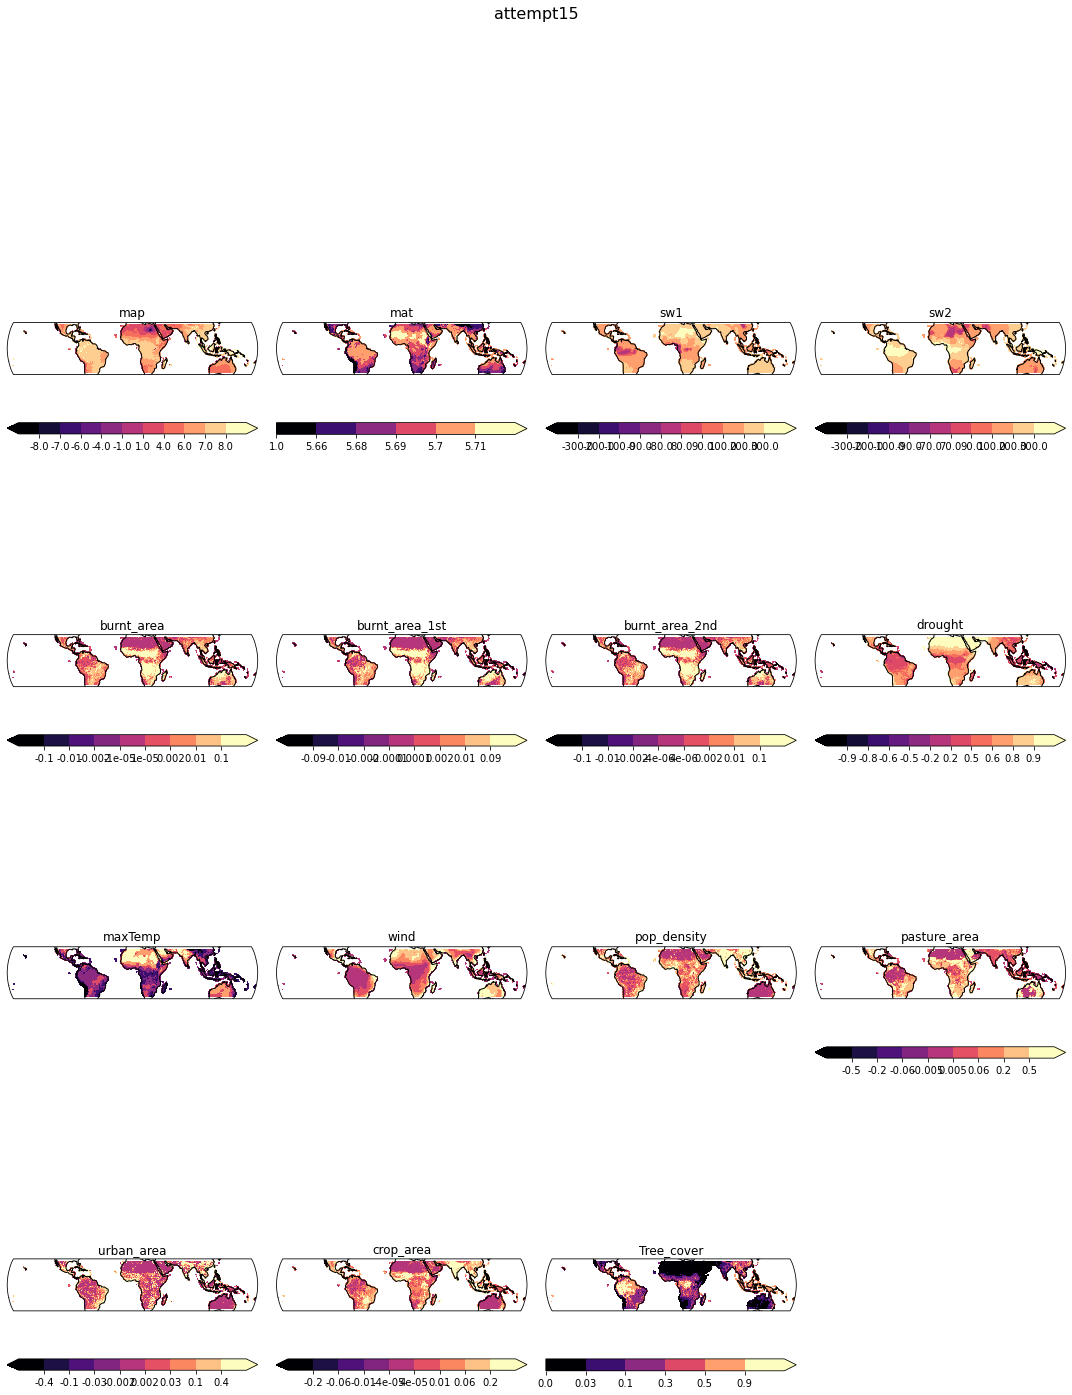

In [5]:
input_data = inputs[0][0][0][0]
nd = 0

plt.figure(figsize = (15, 20))

for key, dat in input_data.items():
    nd = nd + 1
    dat.long_name = key
    plot_lonely_cube(dat, 4, 4, nd, cmap = 'magma', levels = None)
    plt.suptitle(title_output, fontsize=16)
    plt.subplots_adjust(top=0.88)


In [6]:
class DeathCon(object):
    def __init__(self, data, params):
        """
        Initalise parameters and calculates the key variables needed to calculate burnt area.
        """
        self.params = params

        ## finds controls
        self.MAP = self.control_MAP(data['map'])
                                    
        self.MAT = self.control_MAT(data['mat'])
        
        self.SW = self.control_SW(data['sw1'], data['sw2'], self.params['trans_d'])       
        
                                    
        self.Mort = self.control_Mort(data['burnt_area'], data['drought'], data['maxTemp'], data['wind'],
                                      self.params['v_drought'], self.params['v_maxTemp'], 
                                      self.params['v_wind'],
                                      self.params['p_fire'], self.params['p_drought'])

        self.Exclude = self.control_Exclude(data['urban_area'], data['crop_area'], data['pop_density'], 
                                            data['pasture_area'], 
                                            self.params['v_crop'], self.params['v_pas'],
                                            self.params['v_popDen'], self.params['k_popden'])

        ## calculates limiting factor of each control.
        self.standard_MAP     = self.sigmoid(self.MAP,
                                             self.params['MAP_x0'], self.params['MAP_k'])  
        
        self.standard_MAT     = self.sigmoid(self.MAT,
                                            self.params['MAT_x0'], self.params['MAT_k']) 
        
        self.standard_SW      = self.sigmoid(self.SW,
                                            self.params['SW_x0'], self.params['SW_k']) 
        
        self.standard_Mort    = self.sigmoid(self.Mort,
                                            self.params['mort_x0'], -self.params['mort_k']) 
        
        self.standard_Exclude = self.sigmoid(self.Exclude,
                                            self.params['ex_x0'], -self.params['ex_k'])
                                                                           
        self.standard_Energy = self.standard_MAT * self.standard_SW
        self.error = self.params['sigma']
        ## burnt area us just limitation of each control muliplied together.
        self.Tree_cover_mode = self.standard_MAP * self.standard_MAT * self.standard_SW * \
            self.standard_Mort * self.standard_Exclude# * self.params['max_T']
        
        ## find the mean burnt area
        self.Tree_cover_calPDF(data)
        
        self.Tree_cover = self.Tree_cover_mean.copy() #* (1.0-self.p0)
        
        #browser()
        
        #self.standard_MAT    = self.standard_MAT / self.sigmoid(0.0, self.params['MAT_x0'],
        #                                         -self.params['MAT_k'])
        #self.standard_suppression = self.standard_suppression / self.sigmoid(0.0, self.params['suppression_x0'],
        #                                         -self.params['suppression_k'])

        self.potential_MAP = self.potential(self.standard_MAP, "potential_MAP")
        self.potential_MAT = self.potential(self.standard_MAT, "potential_MAT")
        self.potential_SW = self.potential(self.standard_SW, "potential_SW")
        self.potential_Mort = self.potential(self.standard_Mort, "potential_Mortality")
        self.potential_Exclude = self.potential(self.standard_Exclude, "potential_Exclude")
        self.potential_Energy = self.potential(self.standard_Energy, "potential_Energy")
        
        self.sensitivity_MAP = self.sensitivity(self.MAP, self.params['MAP_x0'], self.params['MAP_k'],
                                    self.standard_MAP, "sensitivity_MAP")

        self.sensitivity_MAT = self.sensitivity(self.MAT, self.params['MAT_x0'], -self.params['MAT_k'],
                                    self.standard_MAT, "sensitivity_MAT")

        self.sensitivity_SW = self.sensitivity(self.SW, self.params['SW_x0'], -self.params['SW_k'],
                                    self.standard_SW, "sensitivity_SW")

        self.sensitivity_Exclude = self.sensitivity(self.Exclude, self.params['ex_x0'], self.params['ex_k'],
                                    self.standard_Exclude, "sensitivity_Exclude")


        self.sensitivity_Mort = self.sensitivity(self.Mort, self.params['mort_x0'], -self.params['mort_k'] ,
                                    self.standard_Mort, "sensitivity_Mortality")

        

        self.sensitivity_Energy = self.sensitivity([self.MAT, self.SW], 
                                                   [self.params['MAT_x0'], self.params['SW_x0']],
                                                    [self.params['SW_k'], self.params['SW_k']],
                                                   self.standard_Energy, "sensitivity_Energy")
        ## if the inputs are iris cubes, we can add some useful metadata
        
        self.Tree_cover.long_name = "Tree_cover"
        self.Tree_cover_mode.long_name = "Tree_cover_mode"
        #self.burnt_area_median.long_name = "burnt_area_median"
        self.Tree_cover_mean.long_name = "Tree_cover_mean"

        self.MAP.long_name = "map"
        self.MAP.units = 'no_unit'

        self.MAT.long_name = "mat"
        self.MAT.units = 'no_unit'

        self.SW.long_name = "sw"
        self.SW.units = 'W m-2'

        self.Mort.long_name = "Mortality"
        self.Mort.units = '1'

        self.Exclude.long_name = "Exclude"
        self.Exclude.units = '1'

        self.standard_MAP.long_name     = "standard_MAP"
        self.standard_MAT.long_name     = "standard_MAT"
        self.standard_SW.long_name      = "standard_SW"
        self.standard_Mort.long_name    = "standard_Mortality"
        self.standard_Exclude.long_name = "standard_Exclude"
        self.standard_Energy.long_name  = "standard_Energy"

        self.standard_MAP.units     = '1'
        self.standard_MAT.units     = '1'
        self.standard_SW.units      = '1'
        self.standard_Mort.units    = '1'
        self.standard_Exclude.units = '1'
        self.standard_Energy.units  = '1'
      

    def control_MAP(self, map):
        """
        Definition to describe precip: while we are just returning input for now,
        we include climate potential functions for capability to be modified later.
        """
        out = map.copy()* 1
        return out


    def control_MAT(self, mat):#, min_mat, max_mat):
        """
        Definition to describe temp.
        """
        #mat = mat - min_mat
        #mat = mat / (max_mat - min_mat)
        #mat = tt.clip(mat, 0.0000001, 100000)
        #mat = tt.log(mat)
        out = mat.copy() * 1
        
        return out


    def control_SW(self, sw1, sw2, d):
        """
        Definition to describe short wave
        """
        return sw1 + d * sw2 /(1.0 + d)


    def control_Mort(self, fire, drought, maxTemp, wind, v_drought, v_maxTemp, v_wind,
                     p_fire, p_drought):#, min_maxTemp, max_maxTemp, p_maxTemp):
        """
        Definition of mortality
        """
        #maxTemp = maxTemp - min_maxTemp
        #maxTemp = maxTemp / (max_maxTemp - min_maxTemp)
        #maxTemp = tt.clip(maxTemp, 0.0, 1.0)
        #maxTemp = maxTemp **(p_maxTemp)

        drought = drought.copy() ** (p_drought)

        fire = fire.copy()**(p_fire)
        try:
            mort = fire  +  v_drought * drought  +  v_maxTemp * maxTemp  + v_wind * wind
        except:
            browser()

        return mort / (1.0 + v_drought + v_maxTemp + v_wind)

    def control_Exclude(self, urban_area, crop_area, pasture_area, pop_density, v_crop, v_pas, v_pop, k_popden):
        """
        Definition for the measure of fire supression
        """
        pop_density = pop_density.copy()
        pop_density.data = 1 - np.exp(pop_density.data * (-1.0/ k_popden))
        excl = urban_area  +  v_crop * crop_area + v_pas * pasture_area + v_pop * pop_density 

        return excl / (1.0 + v_crop + v_pas + v_pop)



    def sensitivity(self, x, x0, k, fi, long_name = None):
        
        if type(x) is list:
            gradients = [self.gradient(xi, x0i, ki) for xi, x0i, ki in zip(x, x0, k)]
            gradient = gradients[0]
            for g in gradients[1:]: gradient *= gradient
            
            gradient.data = gradient.data**len(gradients)            
        else:
            gradient = self.gradient(x, x0, k)
            
        if type(fi) is list:
            fis = fi.copy()
            fi = fis[0]
            for f in fis: fi *= f
                
            fi.data = fi.data**len(fis)
            
        sens = gradient * self.control_removal(fi)

        try: sens.units = '1'
        except: pass

        if long_name is not None:
            try: sens.long_name = long_name
            except: browser()
        return sens


    def control_removal(self, fi):
        return self.Tree_cover_mode/fi


    def potential(self, fi, long_name = None):
        out = fi.copy()
        out.data = self.Tree_cover_mode.data * ((1/out.data) - 1)

        try: out.units = '1'
        except: pass

        if long_name is not None:
            try: out.long_name = long_name
            except: pass
        return out


    def gradient(self, x, x0, k, dx = 0.0001):

        f1 = self.sigmoid(x + dx, x0, k)
        f2 = self.sigmoid(x - dx, x0, k)

        n1 = self.sigmoid(x0 + dx, x0, k)
        n2 = self.sigmoid(x0 - dx, x0, k)

        try:
            f1 = (f1 - f2)/(n1 - n2)
        except:
            f1.data = (f1.data - f2.data) / (n1.data - n2.data)

        return f1


    def sigmoid(self, x, x0,k):
        """
        Sigmoid function to describe limitation using tensor
        """
        try:
            out = x.copy()
            out.data = -k*(x.data - x0)
            out.data = 1.0/(1.0 + np.exp(out.data))
            x = out
        except:
            x = -k * (x - x0)
            x = 1.0/(1.0 + np.exp(x))
        return x
    
    def Tree_cover_calPDF(self, data):
        
        mask = np.logical_not(self.Tree_cover_mode.data.mask)
        self.Tree_cover_pdf = newCubes3D('Tree_cover', 0.5,
                                         data['Tree_cover'])
        
        self.Tree_cover_mean = self.Tree_cover_mode.copy()
        self.Tree_cover_mean.data[mask] = 0.0
        
        level_no = self.Tree_cover_pdf.coord('model_level_number').points
        
        dist = norm(npLogit(self.Tree_cover_mode.data[mask]), self.error)
        
        x = self.Tree_cover_pdf.coord('model_level_number').points
        for k in range(1, self.Tree_cover_pdf.shape[0]):       
            self.Tree_cover_pdf.data[k][mask] = dist.pdf(x[k])
            self.Tree_cover_mean.data[mask]  = self.Tree_cover_mean.data[mask] +  dist.pdf(x[k]) *(1/(1+np.exp(-x[k])))
                                     
        PDFtot = self.Tree_cover_pdf.collapsed(['model_level_number'], iris.analysis.SUM)
        
        self.Tree_cover_pdf.long_name     = "Tree_cover_pdf"
        self.Tree_cover_mean.data = self.Tree_cover_mean.data/ PDFtot.data
        
    def Prob_beta_given_Tree_cover(self, TC):
        mask = ~np.isnan(TC.data) * ~self.Tree_cover_mode.data.mask        
        ncells = np.sum(mask)
        mu = npLogit(TC.data[mask], ncells) - npLogit(self.Tree_cover_mode.data[mask], ncells)
        
        sigma = self.params['sigma']
        prob = - np.log(sigma * np.sqrt(2.0 * math.pi)) - np.mean(mu**2.0)/(2.0*sigma**2.0)
        return np.exp(prob)
        
        

In [7]:
def bootSamples(x, samples, nsample = 2):
    def bootSamples(x):
        #browser()or np.ma.is_masked(test)
        test = np.ma.sum(x)
        
        out = np.repeat(0, nsample)
        if test==0 : return out
        try:
            out = np.random.choice(samples, nsample, p =x/np.sum(x))
        except:
            out = np.repeat(0, nsample)
        return out
    x = np.apply_along_axis(bootSample, 0, x)
    return(x)



In [8]:
def runModelExperiment(input, paramLoc = None):
    
    input_data = input[0]
    params = input[1]
    
    if paramLoc is None: paramLoc = params["sigma"].idxmin()
    print("running")    
    
    model = DeathCon(input_data, params.loc[paramLoc])
    #model.Prob_beta_given_Tree_cover(inputs[0][0][0][0]['Tree_cover'])
    return model
    PDF = model.Tree_cover_pdf.data
    
    mask = PDF[0,:,:].mask == False
    TCs = model.Tree_cover_pdf.coord("model_level_number").points
    TCs = 1/(1+np.exp(-BAs))

    PDF = bootSamples(PDF[:,mask], TCs, 10)

    
    model_out.Tree_cover_pdf.data[:] = 0.0
    
    def posterize(i): return np.argmin(np.abs(i-TCs))
    vpost = np.vectorize(posterize)
    PDF_out = vpost(PDF_out)
    for PDF in PDF_out:
        for i in np.unique(PDF):
            test = PDF == i
            try:
                model_out.Tree_cover_pdf.data[i][mask] =+ test
            except:
                browser()
            
           
    return model_out
model = runModelExperiment(inputs[0][0][0])
#models = [[[runModelExperiment(input) for input in i] for i in j] for j in inputs]

running


### Tree Cover plot

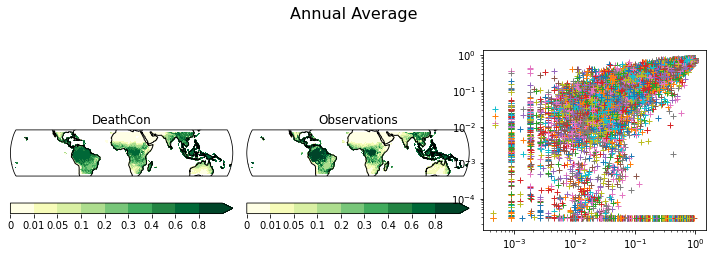

In [9]:
def plot_model_Tree_cover(model, level, addObs = False, 
                          figsize = (10, 6), Title = "Annual Average ", N = 2, M = 3, n = 0, 
                          addScatter = False, *args, **kw):
    if figsize is not None: plt.figure(figsize = figsize)
    
    sim = model.Tree_cover_mean    
    sim.long_name = "DeathCon"
    plot_lonely_cube(sim, N, M, n + 1, levels = level, cmap = "brewer_YlGn_09", *args, **kw)
    
    obs = inputs[0][0][0][0]["Tree_cover"]
    if addObs:
        obs.long_name = "Observations"
        plot_lonely_cube(obs, N, M, n + 2, levels = level, cmap = "brewer_YlGn_09", *args, **kw)
    
    if addScatter:
        plt.subplot(N, M, n + 3)
        plt.plot(obs.data, sim.data, '+')
        plt.gca().set_yscale('log')
        plt.gca().set_xscale('log')
    plt.subplots_adjust(top=0.88)
    plt.suptitle(Title, fontsize=16)
    plt.subplots_adjust(top=0.88)

            
clevels = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8]


    
#for model in models: 
#    for mod in model: 
#        for m in mod:
#            plot_model_Tree_cover(m, clevels, extend = 'max', addObs = True, addScatter = True)
plot_model_Tree_cover(model, clevels, extend = 'max', addObs = True, addScatter = True)    
#plot_lonely_cube(model[0],[1], N, M, n + 1, levels = level, cmap = "brewer_YlOrRd_09", extend = 'max')

### Controls plot

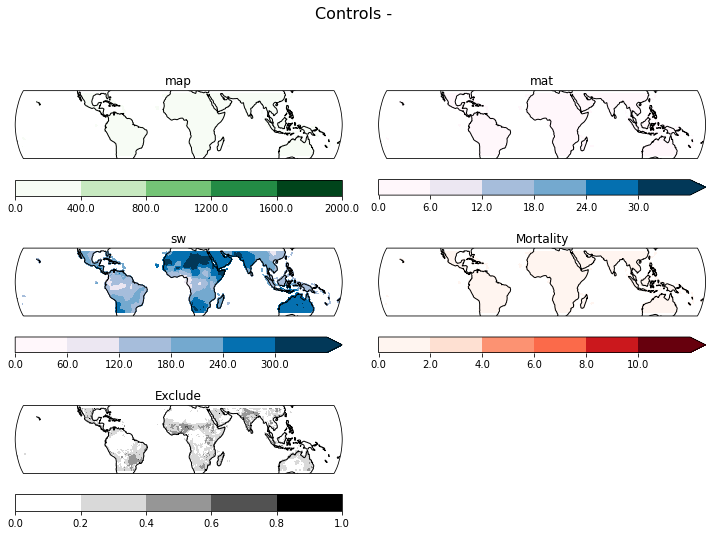

In [10]:
cmap_MAP = 'brewer_Greens_09'
cmap_Energy = 'brewer_PuBu_09'
cmap_Mortality = 'brewer_Reds_09'
cmap_Exclusion= 'brewer_Greys_09'

levels_frac = np.array([0,0.2, 0.4, 0.6,  0.8,  1.0])
#levels_frac = [0,0.45,  0.5, 0.55, 1.0]
#levels_ignitions = np.array([0, 100, 200,500, 1000, 2000, 5000])/5000.0
#levels_moisture = [0, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6]
    
def plotModComponet(comp, n, name = None, levels = None, scale = None, cmap = "brewer_YlOrRd_09",
                    N = 3, M = 2, *args, **kws):
    
    #comp = comp[mnths].collapsed('time', iris.analysis.MEAN)
    if name  is not None: comp.long_name = name
    plot_lonely_cube(comp, N, M, n, levels = levels, cmap = cmap, *args, **kws)


def plot_fire_month(model, Title = '',  **kw):    
    plt.figure(figsize = (10, 7.5))
    model = model
    plotModComponet(model.MAP, 1, cmap = cmap_MAP, levels = levels_frac*2000, **kw)
    plotModComponet(model.MAT, 2, cmap = cmap_Energy, levels = levels_frac*30, extend = 'max', **kw)
    plotModComponet(model.SW, 3, cmap = cmap_Energy, levels = levels_frac*300, extend = 'max', **kw)
    plotModComponet(model.Mort, 4, cmap = cmap_Mortality, levels = levels_frac*10, extend = 'max', **kw)
    plotModComponet(model.Exclude, 5, cmap = cmap_Exclusion, levels = levels_frac, **kw)
    plt.suptitle('Controls - ' + Title, fontsize=16)
    plt.subplots_adjust(top=0.88)
    
            
plot_fire_month(model)

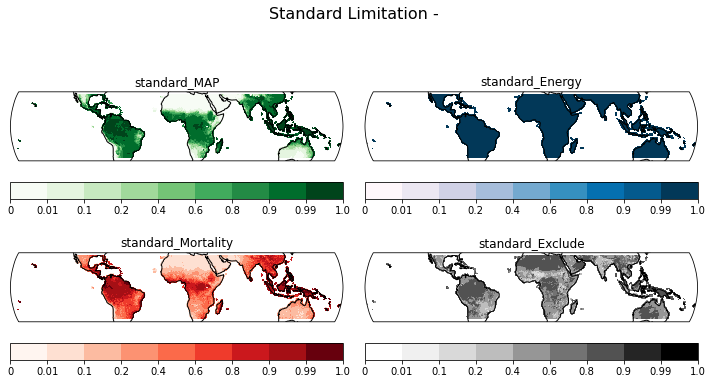

In [11]:
levels = [0, 0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 0.99, 1.0]
#levels = [0, 0.01, 0.02, 0.05, 0.1, 0.2,  0.5]
def plot_fire_month(model, **kw):
    
    plt.figure(figsize = (10, 7.5))
    plotModComponet(model.standard_MAP, 1, cmap = cmap_MAP, levels = levels, **kw)
    plotModComponet(model.standard_Energy, 2, cmap = cmap_Energy, levels = levels, **kw)
    plotModComponet(model.standard_Mort, 3, cmap = cmap_Mortality, levels = levels, **kw)
    plotModComponet(model.standard_Exclude, 4, cmap = cmap_Exclusion, levels = levels, **kw)
    plt.suptitle('Standard Limitation - ', fontsize=16)
    plt.subplots_adjust(top=0.88)
            
plot_fire_month(model)

### Bootstrapping Postieor
So, thats all been looking at just one, albiet very likely parameter combination. The really useful thing about this framework is the uncertainty in the parameters. I'll probably add some visulaisation of that here at some point, but the main thing is to sample the postiror so you can go away and do you own analysis. 

First off some switches. Which things do you want to get a sample for?:

* ```output_controls``` for fuel, moistire, igntions and sepression
* ```output_<<<xxx>>``` output the <<xxx>> type of limitation or sensitivity.

The more you have switched on, the long it takes. But the more cool results you'll have!

In [12]:
output_controls = True
output_standard_limitation = True
output_potential_limitation = True
output_sensitivity = True
output_fullPost = True
grab_cache = True

Next we have the number of parameter combinations we want to sample (```n_posterior_sample```) - the more the better detail but the longer the time. ```step``` is descibed the sampling gap for the paramater combination + error. The unit is fractional burnt area. The small the step, the more detailed you overall postiror (i.e P(fire| (B | Obs)), but the slower. You might not need P(fire| (B | Obs). In which case, set this to ```None``` and enjoy the extra quick processing time!

```qs``` is the percentiles we'll use to summerise the prbablity density curves at the end. I just set this to 1-99% at 1% intervals... might be overkill (maybe you just need 1, 5, 10, 25, 50, 75, 90, 95, 99 for example). But its so quick compared to everything else, that I'd rather set this detailed so I dont have to rerun.

Finally, we set a directory to stick a load of outputs we're about to generate

In [13]:
n_posterior_sample = 101
n_posterior_full_sample = 11
#qs = np.arange(1, 100, 1)
qs = np.array([1, 5, 10, 25, 50, 75, 90, 95, 99])
output_dir = '../data/sampled_posterior/'

TCs = model.Tree_cover_pdf.coord("model_level_number").points
TCs = 1/(1+np.exp(-TCs))

In [14]:
def weighted_percentile(data, percents, weights=None):
    ''' percents in units of 1%
        weights specifies the frequency (count) of data.
    '''
    if weights is None:
        return np.percentile(data, percents)
    ind=np.argsort(data)
    d=data[ind]
    w=weights[ind]
    p=1.*w.cumsum()/w.sum()*100
    y=np.interp(percents, p, d)
    return y

In [15]:
def mkDir(dir):
    try: os.mkdir(dir)  
    except: pass

In [16]:
mkDir(output_dir)

output_diri = output_dir + title_output +'/'
mkDir(output_diri)


In [17]:
def input4Experiment(input, exp):
    exp = exp[1:]
    if len(exp) == 0: return input
    
    cinput = input[0].copy()
    for expi in exp:
        newdat = input[0][expi[0]].copy()
        if not isinstance(expi[1], str):
            newdat.data[:] = expi[1]            
        else:
            if 'PLUS' in expi[1]: 
                newdat.data += float(expi[1].replace('PLUS', ''))
            else:
                newdat.data = input[0][expi[1]].data.copy()
        
        cinput[expi[0]] = newdat
        
    return [cinput, input[1]]

In [18]:
def summary_cubes(tree_outi, dir, csamples = None, ratio = False, fileN = 'model_summary-nEns-'): 
    #fileN = 'model_summary-nEns-' if csamples is None else 'model_summary-nEns-diff'
        
    outFile = dir + fileN + str(len(tree_outi)) + '.nc'
    print(outFile)
    
    if isfile(outFile) and grab_cache: return iris.load(outFile)
    tree_out = []
    for i in range(len(iris.load(tree_outi[0]))):
        outi = []
        if csamples is None: 
            for file in tree_outi:
                out = iris.load(file)
                outi = outi + [out[i].data]
        else:
            for file1, file2 in zip(tree_outi, csamples):
                out  = iris.load(file1)
                out2 = iris.load(file2)
                if ratio: 
                    outi = outi + [1 - (out2[i].data/out[i].data)]
                else:
                    outi = outi + [out[i].data - out2[i].data]
                    #outi = outi + [out[i].data - out2[i].data]
                
        
        try:
            percentile_cube = newCubes3D("Tree_cover", qs, out[i]) 
            percentile_cube.data = np.percentile(np.array(outi), qs, 0)
        except:
            browser()
        tree_out = tree_out + [percentile_cube]
            
    
    tree_out = iris.cube.CubeList(tree_out) 
    iris.save(tree_out, outFile) 
    return tree_out
    

In [19]:
def bootModel(input, fr, dr, pr, exp, p_betaY_in = None):
    output_dirii = output_diri + '/' + exp[0] + '/'
    mkDir(output_dirii)    
    output_diriii = output_dirii + '/' + fr + '_' + dr + '_' + pr + '/'
    mkDir(output_diriii)   
    
    input = input4Experiment(input, exp)
    outfiles = []
    
    pInfoFile = output_diriii + 'Prob_info.csv'
    if not isfile(pInfoFile) or not grab_cache:
        with open(pInfoFile, 'w') as f:
            f.write("Ensemble no., P given TC")
            f.write("\n")
            
    PostOutFile = output_diriii + 'fullPost-nEns-' +  str(n_posterior_sample) + '.nc'
    testMakePost = output_fullPost * isfile(PostOutFile) * ~grab_cache
    n_posterior = input[1].shape[0]
    ngap = int(n_posterior/(n_posterior_sample-1))    
    en = 0
    ens_ids = range(0, n_posterior, ngap)
    
    if ngap == 0: ngap = 1
        
    for i in ens_ids:
        outFile = output_diriii + 'sample_no_' + str(i) +'.nc'
        print(outFile)
        if not isfile(outFile) or not grab_cache:
            model = runModelExperiment(input, i)    
            
            Tree_cover = model.Tree_cover_mean
            cubes = [model.Tree_cover_mean, model.Tree_cover_mode]  
            if output_controls:
                cubes = cubes + [model.MAP, model.MAT, 
                                 model.SW, model.Mort, model.Exclude]

            if output_standard_limitation:
                cubes = cubes + [model.standard_MAP, model.standard_MAT, model.standard_SW, 
                                 model.standard_Mort, model.standard_Exclude, model.standard_Energy] 

            if output_potential_limitation:
                cubes = cubes + [model.potential_MAP, model.potential_MAT, model.potential_SW, 
                                 model.potential_Mort, model.potential_Exclude, model.potential_Energy]

            if output_sensitivity:
                cubes = cubes + [model.sensitivity_MAP, model.sensitivity_MAT, model.sensitivity_SW, 
                                 model.sensitivity_Mort, model.sensitivity_Exclude, model.sensitivity_Energy]
            if output_fullPost:
                cubes = cubes + [model.Tree_cover_pdf]
            cubes = iris.cube.CubeList(cubes) 
            
            Pval = model.Prob_beta_given_Tree_cover(input[0]['Tree_cover'])
            with open(pInfoFile, 'a') as f:
                f.write(str(i) + ',' + str(Pval) + "\n")
            iris.save(cubes, outFile)
            
        
        outfiles.append(outFile)
        
        if testMakePost:
            sample_pdf = iris.load(outFile, 'Tree_cover_pdf')[0]
            if i == 0:
                fullPDF = sample_pdf.copy()
            else:
                fullPDF.data =+ sample_pdf.data      
    
    #summary_cubes(outfiles, output_diriii)

    if testMakePost:
        print(PostOutFile)
        iris.save(fullPDF, PostOutFile) 
    
    
    p_betaY = np.genfromtxt(pInfoFile, delimiter = ',', skip_header = 1)[:,1]

    return outfiles, p_betaY


In [22]:
experiment = [["control"    ,                                                                    ],
              ["noFire"     , ["burnt_area"  ,  0.0]                                             ],            
              ["noWind"     , ["wind"        ,  0.0]                                             ],
              ["noDrought"  , ["drought"     ,  0.0]                                             ],
              ["noPop"      , ["pop_density" ,  0.0]                                             ],
              ["noUrban"    , ["urban_area"  ,  0.0]                                             ],
              ["noCrop"     , ["crop_area"   ,  0.0]                                             ],
              ["noPas"      , ["pasture_area",  0.0]                                             ],
              ["noTasMort"  , ["maxTemp"     ,  0.0]                                             ],
              ["noMAP"      , ["map"         , 99.9],                                            ],
              ["noNoneMAT"  , ["mat"         , 99.9], ["maxTemp"     , 0.0], ["drought", 0.0],
                              ["sw1"         ,  0.0], ["sw2"         , 0.0], ["wind"   , 0.0]    ],
              ["noHumans"   , ["pop_density" ,  0.0], ["urban_area"  ,  0.0], 
                              ["crop_area"   ,  0.0], ["pasture_area",  0.0]                     ],
              ["noExclusion", ["pasture_area",  0.0], ["urban_area"  ,  0.0], 
                              ["crop_area"   ,  0.0], ["pop_density" ,  0.0]                     ], 
              ["noMortality", ["maxTemp"     ,  0.0], ["drought"     ,  0.0],
                              ["burnt_area"  ,  0.0]                                             ]]

def runExp(exp, index = None, csamples = None):
    print(exp)
    samples = []
    p_betaYs = []
    output_dirii = output_diri + '/' + exp[0] + '/'
    
    indexFile = output_dirii + 'index-nEns-' +  str(n_posterior_full_sample) + '-from-' + str(n_posterior_sample) +'.csv'
    
    if isfile(indexFile) and grab_cache and csamples is not None: 
        return np.genfromtxt(indexFile, delimiter = ',', skip_header = 1)[:,1].astype(int)
    
    for fr, iii in zip(fire_datasets, inputs):
        for dr, ii in zip(drought_vars, iii):
            for pr, i in zip(pr_datasets, ii):
                sample, p_betaY = bootModel(i, fr, dr, pr, exp)
                samples.append(sample)
                p_betaYs.append(p_betaY)
             
    npsamples = np.array(samples).flatten()#reshape(-1,np.array(samples).shape[-1])
    npp_betaYs = np.array(p_betaYs).flatten()#.reshape(npsamples.shape[0])
    if index is None:
        try:
            index = np.random.choice(np.arange(0,len(npp_betaYs)), size = n_posterior_full_sample, replace = True, p = npp_betaYs/np.sum(npp_betaYs))
        except:
            browser()
    try:
        tree_outi = npsamples[index]
    except:
        browser()
    
    
    mkDir(output_dirii)
    summary_cubes(tree_outi, output_dirii)
    if csamples is not None:
        summary_cubes(tree_outi, output_dirii, csamples = csamples, fileN = 'model_summary-nEns-diff')
        #summary_cubes(tree_outi, output_dirii, csamples = csamples, 
        #              ratio = True, fileN = 'model_summary-nEns-ratio')
    
    pd.DataFrame(index).to_csv(indexFile)
    
    return index, tree_outi


index, csamples = runExp(experiment[0])  

for exp in experiment[1:]:                
    runExp(exp, index = index, csamples = csamples)
    

['control']
../data/sampled_posterior/attempt15//control//GFED_four_s_MADD_GPCC/sample_no_0.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADD_GPCC/sample_no_300.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADD_GPCC/sample_no_600.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADD_GPCC/sample_no_900.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADD_GPCC/sample_no_1200.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADD_GPCC/sample_no_1500.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADD_GPCC/sample_no_1800.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADD_GPCC/sample_no_2100.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADD_GPCC/sample_no_2400.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADD_GPCC/sample_no_2700.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADD_GPCC/sample_no_3000.nc
../data/sampled_posterior/attempt15//control//GF

../data/sampled_posterior/attempt15//control//GFED_four_s_MADD_CRU/sample_no_1200.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADD_CRU/sample_no_1500.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADD_CRU/sample_no_1800.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADD_CRU/sample_no_2100.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADD_CRU/sample_no_2400.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADD_CRU/sample_no_2700.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADD_CRU/sample_no_3000.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADD_CRU/sample_no_3300.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADD_CRU/sample_no_3600.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADD_CRU/sample_no_3900.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADD_CRU/sample_no_4200.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADD_CR

../data/sampled_posterior/attempt15//control//GFED_four_s_MADD_MSWEP/sample_no_0.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADD_MSWEP/sample_no_300.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADD_MSWEP/sample_no_600.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADD_MSWEP/sample_no_900.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADD_MSWEP/sample_no_1200.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADD_MSWEP/sample_no_1500.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADD_MSWEP/sample_no_1800.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADD_MSWEP/sample_no_2100.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADD_MSWEP/sample_no_2400.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADD_MSWEP/sample_no_2700.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADD_MSWEP/sample_no_3000.nc
../data/sampled_posterior/attempt15//control//GFE

../data/sampled_posterior/attempt15//control//GFED_four_s_MADD_CMORPH/sample_no_12900.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADD_CMORPH/sample_no_13200.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADD_CMORPH/sample_no_13500.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADD_CMORPH/sample_no_13800.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADD_CMORPH/sample_no_14100.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADD_CMORPH/sample_no_14400.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADD_CMORPH/sample_no_14700.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADD_CMORPH/sample_no_15000.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADD_CMORPH/sample_no_15300.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADD_CMORPH/sample_no_15600.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADD_CMORPH/sample_no_15900.nc
../data/sampled_poste

../data/sampled_posterior/attempt15//control//GFED_four_s_MADM_GPCC/sample_no_21600.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADM_GPCC/sample_no_21900.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADM_GPCC/sample_no_22200.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADM_GPCC/sample_no_22500.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADM_GPCC/sample_no_22800.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADM_GPCC/sample_no_23100.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADM_GPCC/sample_no_23400.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADM_GPCC/sample_no_23700.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADM_GPCC/sample_no_24000.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADM_GPCC/sample_no_24300.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADM_GPCC/sample_no_24600.nc
../data/sampled_posterior/attempt15//contro

../data/sampled_posterior/attempt15//control//GFED_four_s_MADM_MSWEP/sample_no_0.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADM_MSWEP/sample_no_300.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADM_MSWEP/sample_no_600.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADM_MSWEP/sample_no_900.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADM_MSWEP/sample_no_1200.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADM_MSWEP/sample_no_1500.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADM_MSWEP/sample_no_1800.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADM_MSWEP/sample_no_2100.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADM_MSWEP/sample_no_2400.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADM_MSWEP/sample_no_2700.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADM_MSWEP/sample_no_3000.nc
../data/sampled_posterior/attempt15//control//GFE

../data/sampled_posterior/attempt15//control//GFED_four_s_MADM_CMORPH/sample_no_17100.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADM_CMORPH/sample_no_17400.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADM_CMORPH/sample_no_17700.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADM_CMORPH/sample_no_18000.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADM_CMORPH/sample_no_18300.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADM_CMORPH/sample_no_18600.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADM_CMORPH/sample_no_18900.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADM_CMORPH/sample_no_19200.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADM_CMORPH/sample_no_19500.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADM_CMORPH/sample_no_19800.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MADM_CMORPH/sample_no_20100.nc
../data/sampled_poste

../data/sampled_posterior/attempt15//control//GFED_four_s_MConc_CRU/sample_no_3000.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MConc_CRU/sample_no_3300.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MConc_CRU/sample_no_3600.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MConc_CRU/sample_no_3900.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MConc_CRU/sample_no_4200.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MConc_CRU/sample_no_4500.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MConc_CRU/sample_no_4800.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MConc_CRU/sample_no_5100.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MConc_CRU/sample_no_5400.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MConc_CRU/sample_no_5700.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MConc_CRU/sample_no_6000.nc
../data/sampled_posterior/attempt15//control//GFED_fou

../data/sampled_posterior/attempt15//control//GFED_four_s_MConc_CMORPH/sample_no_4200.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MConc_CMORPH/sample_no_4500.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MConc_CMORPH/sample_no_4800.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MConc_CMORPH/sample_no_5100.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MConc_CMORPH/sample_no_5400.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MConc_CMORPH/sample_no_5700.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MConc_CMORPH/sample_no_6000.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MConc_CMORPH/sample_no_6300.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MConc_CMORPH/sample_no_6600.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MConc_CMORPH/sample_no_6900.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MConc_CMORPH/sample_no_7200.nc
../data/sampled_poste

../data/sampled_posterior/attempt15//control//GFED_four_s_MDDM_GPCC/sample_no_17400.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MDDM_GPCC/sample_no_17700.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MDDM_GPCC/sample_no_18000.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MDDM_GPCC/sample_no_18300.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MDDM_GPCC/sample_no_18600.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MDDM_GPCC/sample_no_18900.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MDDM_GPCC/sample_no_19200.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MDDM_GPCC/sample_no_19500.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MDDM_GPCC/sample_no_19800.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MDDM_GPCC/sample_no_20100.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MDDM_GPCC/sample_no_20400.nc
../data/sampled_posterior/attempt15//contro

../data/sampled_posterior/attempt15//control//GFED_four_s_MDDM_MSWEP/sample_no_0.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MDDM_MSWEP/sample_no_300.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MDDM_MSWEP/sample_no_600.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MDDM_MSWEP/sample_no_900.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MDDM_MSWEP/sample_no_1200.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MDDM_MSWEP/sample_no_1500.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MDDM_MSWEP/sample_no_1800.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MDDM_MSWEP/sample_no_2100.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MDDM_MSWEP/sample_no_2400.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MDDM_MSWEP/sample_no_2700.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MDDM_MSWEP/sample_no_3000.nc
../data/sampled_posterior/attempt15//control//GFE

../data/sampled_posterior/attempt15//control//GFED_four_s_MDDM_CMORPH/sample_no_15600.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MDDM_CMORPH/sample_no_15900.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MDDM_CMORPH/sample_no_16200.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MDDM_CMORPH/sample_no_16500.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MDDM_CMORPH/sample_no_16800.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MDDM_CMORPH/sample_no_17100.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MDDM_CMORPH/sample_no_17400.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MDDM_CMORPH/sample_no_17700.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MDDM_CMORPH/sample_no_18000.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MDDM_CMORPH/sample_no_18300.nc
../data/sampled_posterior/attempt15//control//GFED_four_s_MDDM_CMORPH/sample_no_18600.nc
../data/sampled_poste

../data/sampled_posterior/attempt15//control//GFED_four_MADD_CRU/sample_no_4500.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADD_CRU/sample_no_4800.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADD_CRU/sample_no_5100.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADD_CRU/sample_no_5400.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADD_CRU/sample_no_5700.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADD_CRU/sample_no_6000.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADD_CRU/sample_no_6300.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADD_CRU/sample_no_6600.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADD_CRU/sample_no_6900.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADD_CRU/sample_no_7200.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADD_CRU/sample_no_7500.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADD_CRU/sample_no_7800.nc
../d

../data/sampled_posterior/attempt15//control//GFED_four_MADD_MSWEP/sample_no_24000.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADD_MSWEP/sample_no_24300.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADD_MSWEP/sample_no_24600.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADD_MSWEP/sample_no_24900.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADD_MSWEP/sample_no_25200.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADD_MSWEP/sample_no_25500.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADD_MSWEP/sample_no_25800.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADD_MSWEP/sample_no_26100.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADD_MSWEP/sample_no_26400.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADD_MSWEP/sample_no_26700.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADD_MSWEP/sample_no_27000.nc
../data/sampled_posterior/attempt15//control//GFED_fou

../data/sampled_posterior/attempt15//control//GFED_four_MADM_GPCC/sample_no_5400.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADM_GPCC/sample_no_5700.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADM_GPCC/sample_no_6000.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADM_GPCC/sample_no_6300.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADM_GPCC/sample_no_6600.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADM_GPCC/sample_no_6900.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADM_GPCC/sample_no_7200.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADM_GPCC/sample_no_7500.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADM_GPCC/sample_no_7800.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADM_GPCC/sample_no_8100.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADM_GPCC/sample_no_8400.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADM_GPCC/sample_no_

../data/sampled_posterior/attempt15//control//GFED_four_MADM_CRU/sample_no_24900.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADM_CRU/sample_no_25200.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADM_CRU/sample_no_25500.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADM_CRU/sample_no_25800.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADM_CRU/sample_no_26100.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADM_CRU/sample_no_26400.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADM_CRU/sample_no_26700.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADM_CRU/sample_no_27000.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADM_CRU/sample_no_27300.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADM_CRU/sample_no_27600.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADM_CRU/sample_no_27900.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADM_CRU/sample_no_2

../data/sampled_posterior/attempt15//control//GFED_four_MADM_CMORPH/sample_no_0.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADM_CMORPH/sample_no_300.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADM_CMORPH/sample_no_600.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADM_CMORPH/sample_no_900.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADM_CMORPH/sample_no_1200.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADM_CMORPH/sample_no_1500.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADM_CMORPH/sample_no_1800.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADM_CMORPH/sample_no_2100.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADM_CMORPH/sample_no_2400.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADM_CMORPH/sample_no_2700.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADM_CMORPH/sample_no_3000.nc
../data/sampled_posterior/attempt15//control//GFED_four_MADM

../data/sampled_posterior/attempt15//control//GFED_four_MConc_GPCC/sample_no_12900.nc
../data/sampled_posterior/attempt15//control//GFED_four_MConc_GPCC/sample_no_13200.nc
../data/sampled_posterior/attempt15//control//GFED_four_MConc_GPCC/sample_no_13500.nc
../data/sampled_posterior/attempt15//control//GFED_four_MConc_GPCC/sample_no_13800.nc
../data/sampled_posterior/attempt15//control//GFED_four_MConc_GPCC/sample_no_14100.nc
../data/sampled_posterior/attempt15//control//GFED_four_MConc_GPCC/sample_no_14400.nc
../data/sampled_posterior/attempt15//control//GFED_four_MConc_GPCC/sample_no_14700.nc
../data/sampled_posterior/attempt15//control//GFED_four_MConc_GPCC/sample_no_15000.nc
../data/sampled_posterior/attempt15//control//GFED_four_MConc_GPCC/sample_no_15300.nc
../data/sampled_posterior/attempt15//control//GFED_four_MConc_GPCC/sample_no_15600.nc
../data/sampled_posterior/attempt15//control//GFED_four_MConc_GPCC/sample_no_15900.nc
../data/sampled_posterior/attempt15//control//GFED_fou

../data/sampled_posterior/attempt15//control//GFED_four_MConc_MSWEP/sample_no_0.nc
../data/sampled_posterior/attempt15//control//GFED_four_MConc_MSWEP/sample_no_300.nc
../data/sampled_posterior/attempt15//control//GFED_four_MConc_MSWEP/sample_no_600.nc
../data/sampled_posterior/attempt15//control//GFED_four_MConc_MSWEP/sample_no_900.nc
../data/sampled_posterior/attempt15//control//GFED_four_MConc_MSWEP/sample_no_1200.nc
../data/sampled_posterior/attempt15//control//GFED_four_MConc_MSWEP/sample_no_1500.nc
../data/sampled_posterior/attempt15//control//GFED_four_MConc_MSWEP/sample_no_1800.nc
../data/sampled_posterior/attempt15//control//GFED_four_MConc_MSWEP/sample_no_2100.nc
../data/sampled_posterior/attempt15//control//GFED_four_MConc_MSWEP/sample_no_2400.nc
../data/sampled_posterior/attempt15//control//GFED_four_MConc_MSWEP/sample_no_2700.nc
../data/sampled_posterior/attempt15//control//GFED_four_MConc_MSWEP/sample_no_3000.nc
../data/sampled_posterior/attempt15//control//GFED_four_MCon

../data/sampled_posterior/attempt15//control//GFED_four_MConc_CMORPH/sample_no_17700.nc
../data/sampled_posterior/attempt15//control//GFED_four_MConc_CMORPH/sample_no_18000.nc
../data/sampled_posterior/attempt15//control//GFED_four_MConc_CMORPH/sample_no_18300.nc
../data/sampled_posterior/attempt15//control//GFED_four_MConc_CMORPH/sample_no_18600.nc
../data/sampled_posterior/attempt15//control//GFED_four_MConc_CMORPH/sample_no_18900.nc
../data/sampled_posterior/attempt15//control//GFED_four_MConc_CMORPH/sample_no_19200.nc
../data/sampled_posterior/attempt15//control//GFED_four_MConc_CMORPH/sample_no_19500.nc
../data/sampled_posterior/attempt15//control//GFED_four_MConc_CMORPH/sample_no_19800.nc
../data/sampled_posterior/attempt15//control//GFED_four_MConc_CMORPH/sample_no_20100.nc
../data/sampled_posterior/attempt15//control//GFED_four_MConc_CMORPH/sample_no_20400.nc
../data/sampled_posterior/attempt15//control//GFED_four_MConc_CMORPH/sample_no_20700.nc
../data/sampled_posterior/attemp

../data/sampled_posterior/attempt15//control//GFED_four_MDDM_CRU/sample_no_0.nc
../data/sampled_posterior/attempt15//control//GFED_four_MDDM_CRU/sample_no_300.nc
../data/sampled_posterior/attempt15//control//GFED_four_MDDM_CRU/sample_no_600.nc
../data/sampled_posterior/attempt15//control//GFED_four_MDDM_CRU/sample_no_900.nc
../data/sampled_posterior/attempt15//control//GFED_four_MDDM_CRU/sample_no_1200.nc
../data/sampled_posterior/attempt15//control//GFED_four_MDDM_CRU/sample_no_1500.nc
../data/sampled_posterior/attempt15//control//GFED_four_MDDM_CRU/sample_no_1800.nc
../data/sampled_posterior/attempt15//control//GFED_four_MDDM_CRU/sample_no_2100.nc
../data/sampled_posterior/attempt15//control//GFED_four_MDDM_CRU/sample_no_2400.nc
../data/sampled_posterior/attempt15//control//GFED_four_MDDM_CRU/sample_no_2700.nc
../data/sampled_posterior/attempt15//control//GFED_four_MDDM_CRU/sample_no_3000.nc
../data/sampled_posterior/attempt15//control//GFED_four_MDDM_CRU/sample_no_3300.nc
../data/sa

../data/sampled_posterior/attempt15//control//GFED_four_MDDM_MSWEP/sample_no_15000.nc
../data/sampled_posterior/attempt15//control//GFED_four_MDDM_MSWEP/sample_no_15300.nc
../data/sampled_posterior/attempt15//control//GFED_four_MDDM_MSWEP/sample_no_15600.nc
../data/sampled_posterior/attempt15//control//GFED_four_MDDM_MSWEP/sample_no_15900.nc
../data/sampled_posterior/attempt15//control//GFED_four_MDDM_MSWEP/sample_no_16200.nc
../data/sampled_posterior/attempt15//control//GFED_four_MDDM_MSWEP/sample_no_16500.nc
../data/sampled_posterior/attempt15//control//GFED_four_MDDM_MSWEP/sample_no_16800.nc
../data/sampled_posterior/attempt15//control//GFED_four_MDDM_MSWEP/sample_no_17100.nc
../data/sampled_posterior/attempt15//control//GFED_four_MDDM_MSWEP/sample_no_17400.nc
../data/sampled_posterior/attempt15//control//GFED_four_MDDM_MSWEP/sample_no_17700.nc
../data/sampled_posterior/attempt15//control//GFED_four_MDDM_MSWEP/sample_no_18000.nc
../data/sampled_posterior/attempt15//control//GFED_fou

../data/sampled_posterior/attempt15//control//MCD_forty_five_MADD_GPCC/sample_no_0.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADD_GPCC/sample_no_300.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADD_GPCC/sample_no_600.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADD_GPCC/sample_no_900.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADD_GPCC/sample_no_1200.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADD_GPCC/sample_no_1500.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADD_GPCC/sample_no_1800.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADD_GPCC/sample_no_2100.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADD_GPCC/sample_no_2400.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADD_GPCC/sample_no_2700.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADD_GPCC/sample_no_3000.nc
../data/sampled_posterior/a

../data/sampled_posterior/attempt15//control//MCD_forty_five_MADD_CRU/sample_no_13500.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADD_CRU/sample_no_13800.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADD_CRU/sample_no_14100.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADD_CRU/sample_no_14400.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADD_CRU/sample_no_14700.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADD_CRU/sample_no_15000.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADD_CRU/sample_no_15300.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADD_CRU/sample_no_15600.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADD_CRU/sample_no_15900.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADD_CRU/sample_no_16200.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADD_CRU/sample_no_16500.nc
../data/sampled_poste

../data/sampled_posterior/attempt15//control//MCD_forty_five_MADD_MSWEP/sample_no_24300.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADD_MSWEP/sample_no_24600.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADD_MSWEP/sample_no_24900.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADD_MSWEP/sample_no_25200.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADD_MSWEP/sample_no_25500.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADD_MSWEP/sample_no_25800.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADD_MSWEP/sample_no_26100.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADD_MSWEP/sample_no_26400.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADD_MSWEP/sample_no_26700.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADD_MSWEP/sample_no_27000.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADD_MSWEP/sample_no_27300.nc

../data/sampled_posterior/attempt15//control//MCD_forty_five_MADM_GPCC/sample_no_1800.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADM_GPCC/sample_no_2100.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADM_GPCC/sample_no_2400.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADM_GPCC/sample_no_2700.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADM_GPCC/sample_no_3000.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADM_GPCC/sample_no_3300.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADM_GPCC/sample_no_3600.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADM_GPCC/sample_no_3900.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADM_GPCC/sample_no_4200.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADM_GPCC/sample_no_4500.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADM_GPCC/sample_no_4800.nc
../data/sampled_poste

../data/sampled_posterior/attempt15//control//MCD_forty_five_MADM_CRU/sample_no_16500.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADM_CRU/sample_no_16800.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADM_CRU/sample_no_17100.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADM_CRU/sample_no_17400.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADM_CRU/sample_no_17700.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADM_CRU/sample_no_18000.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADM_CRU/sample_no_18300.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADM_CRU/sample_no_18600.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADM_CRU/sample_no_18900.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADM_CRU/sample_no_19200.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADM_CRU/sample_no_19500.nc
../data/sampled_poste

../data/sampled_posterior/attempt15//control//MCD_forty_five_MADM_MSWEP/sample_no_26100.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADM_MSWEP/sample_no_26400.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADM_MSWEP/sample_no_26700.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADM_MSWEP/sample_no_27000.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADM_MSWEP/sample_no_27300.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADM_MSWEP/sample_no_27600.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADM_MSWEP/sample_no_27900.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADM_MSWEP/sample_no_28200.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADM_MSWEP/sample_no_28500.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADM_MSWEP/sample_no_28800.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MADM_MSWEP/sample_no_29100.nc

../data/sampled_posterior/attempt15//control//MCD_forty_five_MConc_GPCC/sample_no_6000.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MConc_GPCC/sample_no_6300.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MConc_GPCC/sample_no_6600.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MConc_GPCC/sample_no_6900.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MConc_GPCC/sample_no_7200.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MConc_GPCC/sample_no_7500.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MConc_GPCC/sample_no_7800.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MConc_GPCC/sample_no_8100.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MConc_GPCC/sample_no_8400.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MConc_GPCC/sample_no_8700.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MConc_GPCC/sample_no_9000.nc
../data/sa

../data/sampled_posterior/attempt15//control//MCD_forty_five_MConc_MSWEP/sample_no_0.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MConc_MSWEP/sample_no_300.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MConc_MSWEP/sample_no_600.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MConc_MSWEP/sample_no_900.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MConc_MSWEP/sample_no_1200.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MConc_MSWEP/sample_no_1500.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MConc_MSWEP/sample_no_1800.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MConc_MSWEP/sample_no_2100.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MConc_MSWEP/sample_no_2400.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MConc_MSWEP/sample_no_2700.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MConc_MSWEP/sample_no_3000.nc
../da

../data/sampled_posterior/attempt15//control//MCD_forty_five_MConc_CMORPH/sample_no_10500.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MConc_CMORPH/sample_no_10800.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MConc_CMORPH/sample_no_11100.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MConc_CMORPH/sample_no_11400.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MConc_CMORPH/sample_no_11700.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MConc_CMORPH/sample_no_12000.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MConc_CMORPH/sample_no_12300.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MConc_CMORPH/sample_no_12600.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MConc_CMORPH/sample_no_12900.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MConc_CMORPH/sample_no_13200.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MConc_CMO

../data/sampled_posterior/attempt15//control//MCD_forty_five_MDDM_GPCC/sample_no_24600.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MDDM_GPCC/sample_no_24900.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MDDM_GPCC/sample_no_25200.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MDDM_GPCC/sample_no_25500.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MDDM_GPCC/sample_no_25800.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MDDM_GPCC/sample_no_26100.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MDDM_GPCC/sample_no_26400.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MDDM_GPCC/sample_no_26700.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MDDM_GPCC/sample_no_27000.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MDDM_GPCC/sample_no_27300.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MDDM_GPCC/sample_no_27600.nc
../data/sa

../data/sampled_posterior/attempt15//control//MCD_forty_five_MDDM_MSWEP/sample_no_2700.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MDDM_MSWEP/sample_no_3000.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MDDM_MSWEP/sample_no_3300.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MDDM_MSWEP/sample_no_3600.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MDDM_MSWEP/sample_no_3900.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MDDM_MSWEP/sample_no_4200.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MDDM_MSWEP/sample_no_4500.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MDDM_MSWEP/sample_no_4800.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MDDM_MSWEP/sample_no_5100.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MDDM_MSWEP/sample_no_5400.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MDDM_MSWEP/sample_no_5700.nc
../data/sa

../data/sampled_posterior/attempt15//control//MCD_forty_five_MDDM_CMORPH/sample_no_10500.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MDDM_CMORPH/sample_no_10800.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MDDM_CMORPH/sample_no_11100.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MDDM_CMORPH/sample_no_11400.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MDDM_CMORPH/sample_no_11700.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MDDM_CMORPH/sample_no_12000.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MDDM_CMORPH/sample_no_12300.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MDDM_CMORPH/sample_no_12600.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MDDM_CMORPH/sample_no_12900.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MDDM_CMORPH/sample_no_13200.nc
../data/sampled_posterior/attempt15//control//MCD_forty_five_MDDM_CMORPH/sample_

../data/sampled_posterior/attempt15//control//meris_MADD_CRU/sample_no_19200.nc
../data/sampled_posterior/attempt15//control//meris_MADD_CRU/sample_no_19500.nc
../data/sampled_posterior/attempt15//control//meris_MADD_CRU/sample_no_19800.nc
../data/sampled_posterior/attempt15//control//meris_MADD_CRU/sample_no_20100.nc
../data/sampled_posterior/attempt15//control//meris_MADD_CRU/sample_no_20400.nc
../data/sampled_posterior/attempt15//control//meris_MADD_CRU/sample_no_20700.nc
../data/sampled_posterior/attempt15//control//meris_MADD_CRU/sample_no_21000.nc
../data/sampled_posterior/attempt15//control//meris_MADD_CRU/sample_no_21300.nc
../data/sampled_posterior/attempt15//control//meris_MADD_CRU/sample_no_21600.nc
../data/sampled_posterior/attempt15//control//meris_MADD_CRU/sample_no_21900.nc
../data/sampled_posterior/attempt15//control//meris_MADD_CRU/sample_no_22200.nc
../data/sampled_posterior/attempt15//control//meris_MADD_CRU/sample_no_22500.nc
../data/sampled_posterior/attempt15//con

../data/sampled_posterior/attempt15//control//meris_MADD_MSWEP/sample_no_28500.nc
../data/sampled_posterior/attempt15//control//meris_MADD_MSWEP/sample_no_28800.nc
../data/sampled_posterior/attempt15//control//meris_MADD_MSWEP/sample_no_29100.nc
../data/sampled_posterior/attempt15//control//meris_MADD_MSWEP/sample_no_29400.nc
../data/sampled_posterior/attempt15//control//meris_MADD_MSWEP/sample_no_29700.nc
../data/sampled_posterior/attempt15//control//meris_MADD_CMORPH/sample_no_0.nc
../data/sampled_posterior/attempt15//control//meris_MADD_CMORPH/sample_no_300.nc
../data/sampled_posterior/attempt15//control//meris_MADD_CMORPH/sample_no_600.nc
../data/sampled_posterior/attempt15//control//meris_MADD_CMORPH/sample_no_900.nc
../data/sampled_posterior/attempt15//control//meris_MADD_CMORPH/sample_no_1200.nc
../data/sampled_posterior/attempt15//control//meris_MADD_CMORPH/sample_no_1500.nc
../data/sampled_posterior/attempt15//control//meris_MADD_CMORPH/sample_no_1800.nc
../data/sampled_poster

../data/sampled_posterior/attempt15//control//meris_MADM_GPCC/sample_no_6600.nc
../data/sampled_posterior/attempt15//control//meris_MADM_GPCC/sample_no_6900.nc
../data/sampled_posterior/attempt15//control//meris_MADM_GPCC/sample_no_7200.nc
../data/sampled_posterior/attempt15//control//meris_MADM_GPCC/sample_no_7500.nc
../data/sampled_posterior/attempt15//control//meris_MADM_GPCC/sample_no_7800.nc
../data/sampled_posterior/attempt15//control//meris_MADM_GPCC/sample_no_8100.nc
../data/sampled_posterior/attempt15//control//meris_MADM_GPCC/sample_no_8400.nc
../data/sampled_posterior/attempt15//control//meris_MADM_GPCC/sample_no_8700.nc
../data/sampled_posterior/attempt15//control//meris_MADM_GPCC/sample_no_9000.nc
../data/sampled_posterior/attempt15//control//meris_MADM_GPCC/sample_no_9300.nc
../data/sampled_posterior/attempt15//control//meris_MADM_GPCC/sample_no_9600.nc
../data/sampled_posterior/attempt15//control//meris_MADM_GPCC/sample_no_9900.nc
../data/sampled_posterior/attempt15//con

../data/sampled_posterior/attempt15//control//meris_MADM_CRU/sample_no_20700.nc
../data/sampled_posterior/attempt15//control//meris_MADM_CRU/sample_no_21000.nc
../data/sampled_posterior/attempt15//control//meris_MADM_CRU/sample_no_21300.nc
../data/sampled_posterior/attempt15//control//meris_MADM_CRU/sample_no_21600.nc
../data/sampled_posterior/attempt15//control//meris_MADM_CRU/sample_no_21900.nc
../data/sampled_posterior/attempt15//control//meris_MADM_CRU/sample_no_22200.nc
../data/sampled_posterior/attempt15//control//meris_MADM_CRU/sample_no_22500.nc
../data/sampled_posterior/attempt15//control//meris_MADM_CRU/sample_no_22800.nc
../data/sampled_posterior/attempt15//control//meris_MADM_CRU/sample_no_23100.nc
../data/sampled_posterior/attempt15//control//meris_MADM_CRU/sample_no_23400.nc
../data/sampled_posterior/attempt15//control//meris_MADM_CRU/sample_no_23700.nc
../data/sampled_posterior/attempt15//control//meris_MADM_CRU/sample_no_24000.nc
../data/sampled_posterior/attempt15//con

../data/sampled_posterior/attempt15//control//meris_MADM_CMORPH/sample_no_3000.nc
../data/sampled_posterior/attempt15//control//meris_MADM_CMORPH/sample_no_3300.nc
../data/sampled_posterior/attempt15//control//meris_MADM_CMORPH/sample_no_3600.nc
../data/sampled_posterior/attempt15//control//meris_MADM_CMORPH/sample_no_3900.nc
../data/sampled_posterior/attempt15//control//meris_MADM_CMORPH/sample_no_4200.nc
../data/sampled_posterior/attempt15//control//meris_MADM_CMORPH/sample_no_4500.nc
../data/sampled_posterior/attempt15//control//meris_MADM_CMORPH/sample_no_4800.nc
../data/sampled_posterior/attempt15//control//meris_MADM_CMORPH/sample_no_5100.nc
../data/sampled_posterior/attempt15//control//meris_MADM_CMORPH/sample_no_5400.nc
../data/sampled_posterior/attempt15//control//meris_MADM_CMORPH/sample_no_5700.nc
../data/sampled_posterior/attempt15//control//meris_MADM_CMORPH/sample_no_6000.nc
../data/sampled_posterior/attempt15//control//meris_MADM_CMORPH/sample_no_6300.nc
../data/sampled_

../data/sampled_posterior/attempt15//control//meris_MConc_GPCC/sample_no_17400.nc
../data/sampled_posterior/attempt15//control//meris_MConc_GPCC/sample_no_17700.nc
../data/sampled_posterior/attempt15//control//meris_MConc_GPCC/sample_no_18000.nc
../data/sampled_posterior/attempt15//control//meris_MConc_GPCC/sample_no_18300.nc
../data/sampled_posterior/attempt15//control//meris_MConc_GPCC/sample_no_18600.nc
../data/sampled_posterior/attempt15//control//meris_MConc_GPCC/sample_no_18900.nc
../data/sampled_posterior/attempt15//control//meris_MConc_GPCC/sample_no_19200.nc
../data/sampled_posterior/attempt15//control//meris_MConc_GPCC/sample_no_19500.nc
../data/sampled_posterior/attempt15//control//meris_MConc_GPCC/sample_no_19800.nc
../data/sampled_posterior/attempt15//control//meris_MConc_GPCC/sample_no_20100.nc
../data/sampled_posterior/attempt15//control//meris_MConc_GPCC/sample_no_20400.nc
../data/sampled_posterior/attempt15//control//meris_MConc_GPCC/sample_no_20700.nc
../data/sampled_

../data/sampled_posterior/attempt15//control//meris_MConc_CRU/sample_no_28200.nc
../data/sampled_posterior/attempt15//control//meris_MConc_CRU/sample_no_28500.nc
../data/sampled_posterior/attempt15//control//meris_MConc_CRU/sample_no_28800.nc
../data/sampled_posterior/attempt15//control//meris_MConc_CRU/sample_no_29100.nc
../data/sampled_posterior/attempt15//control//meris_MConc_CRU/sample_no_29400.nc
../data/sampled_posterior/attempt15//control//meris_MConc_CRU/sample_no_29700.nc
../data/sampled_posterior/attempt15//control//meris_MConc_MSWEP/sample_no_0.nc
../data/sampled_posterior/attempt15//control//meris_MConc_MSWEP/sample_no_300.nc
../data/sampled_posterior/attempt15//control//meris_MConc_MSWEP/sample_no_600.nc
../data/sampled_posterior/attempt15//control//meris_MConc_MSWEP/sample_no_900.nc
../data/sampled_posterior/attempt15//control//meris_MConc_MSWEP/sample_no_1200.nc
../data/sampled_posterior/attempt15//control//meris_MConc_MSWEP/sample_no_1500.nc
../data/sampled_posterior/at

../data/sampled_posterior/attempt15//control//meris_MConc_CMORPH/sample_no_11700.nc
../data/sampled_posterior/attempt15//control//meris_MConc_CMORPH/sample_no_12000.nc
../data/sampled_posterior/attempt15//control//meris_MConc_CMORPH/sample_no_12300.nc
../data/sampled_posterior/attempt15//control//meris_MConc_CMORPH/sample_no_12600.nc
../data/sampled_posterior/attempt15//control//meris_MConc_CMORPH/sample_no_12900.nc
../data/sampled_posterior/attempt15//control//meris_MConc_CMORPH/sample_no_13200.nc
../data/sampled_posterior/attempt15//control//meris_MConc_CMORPH/sample_no_13500.nc
../data/sampled_posterior/attempt15//control//meris_MConc_CMORPH/sample_no_13800.nc
../data/sampled_posterior/attempt15//control//meris_MConc_CMORPH/sample_no_14100.nc
../data/sampled_posterior/attempt15//control//meris_MConc_CMORPH/sample_no_14400.nc
../data/sampled_posterior/attempt15//control//meris_MConc_CMORPH/sample_no_14700.nc
../data/sampled_posterior/attempt15//control//meris_MConc_CMORPH/sample_no_1

../data/sampled_posterior/attempt15//control//meris_MDDM_CRU/sample_no_0.nc
../data/sampled_posterior/attempt15//control//meris_MDDM_CRU/sample_no_300.nc
../data/sampled_posterior/attempt15//control//meris_MDDM_CRU/sample_no_600.nc
../data/sampled_posterior/attempt15//control//meris_MDDM_CRU/sample_no_900.nc
../data/sampled_posterior/attempt15//control//meris_MDDM_CRU/sample_no_1200.nc
../data/sampled_posterior/attempt15//control//meris_MDDM_CRU/sample_no_1500.nc
../data/sampled_posterior/attempt15//control//meris_MDDM_CRU/sample_no_1800.nc
../data/sampled_posterior/attempt15//control//meris_MDDM_CRU/sample_no_2100.nc
../data/sampled_posterior/attempt15//control//meris_MDDM_CRU/sample_no_2400.nc
../data/sampled_posterior/attempt15//control//meris_MDDM_CRU/sample_no_2700.nc
../data/sampled_posterior/attempt15//control//meris_MDDM_CRU/sample_no_3000.nc
../data/sampled_posterior/attempt15//control//meris_MDDM_CRU/sample_no_3300.nc
../data/sampled_posterior/attempt15//control//meris_MDDM_C

../data/sampled_posterior/attempt15//control//meris_MDDM_MSWEP/sample_no_15000.nc
../data/sampled_posterior/attempt15//control//meris_MDDM_MSWEP/sample_no_15300.nc
../data/sampled_posterior/attempt15//control//meris_MDDM_MSWEP/sample_no_15600.nc
../data/sampled_posterior/attempt15//control//meris_MDDM_MSWEP/sample_no_15900.nc
../data/sampled_posterior/attempt15//control//meris_MDDM_MSWEP/sample_no_16200.nc
../data/sampled_posterior/attempt15//control//meris_MDDM_MSWEP/sample_no_16500.nc
../data/sampled_posterior/attempt15//control//meris_MDDM_MSWEP/sample_no_16800.nc
../data/sampled_posterior/attempt15//control//meris_MDDM_MSWEP/sample_no_17100.nc
../data/sampled_posterior/attempt15//control//meris_MDDM_MSWEP/sample_no_17400.nc
../data/sampled_posterior/attempt15//control//meris_MDDM_MSWEP/sample_no_17700.nc
../data/sampled_posterior/attempt15//control//meris_MDDM_MSWEP/sample_no_18000.nc
../data/sampled_posterior/attempt15//control//meris_MDDM_MSWEP/sample_no_18300.nc
../data/sampled_

../data/sampled_posterior/attempt15//control//meris_MDDM_CMORPH/sample_no_23100.nc
../data/sampled_posterior/attempt15//control//meris_MDDM_CMORPH/sample_no_23400.nc
../data/sampled_posterior/attempt15//control//meris_MDDM_CMORPH/sample_no_23700.nc
../data/sampled_posterior/attempt15//control//meris_MDDM_CMORPH/sample_no_24000.nc
../data/sampled_posterior/attempt15//control//meris_MDDM_CMORPH/sample_no_24300.nc
../data/sampled_posterior/attempt15//control//meris_MDDM_CMORPH/sample_no_24600.nc
../data/sampled_posterior/attempt15//control//meris_MDDM_CMORPH/sample_no_24900.nc
../data/sampled_posterior/attempt15//control//meris_MDDM_CMORPH/sample_no_25200.nc
../data/sampled_posterior/attempt15//control//meris_MDDM_CMORPH/sample_no_25500.nc
../data/sampled_posterior/attempt15//control//meris_MDDM_CMORPH/sample_no_25800.nc
../data/sampled_posterior/attempt15//control//meris_MDDM_CMORPH/sample_no_26100.nc
../data/sampled_posterior/attempt15//control//meris_MDDM_CMORPH/sample_no_26400.nc
../d

../data/sampled_posterior/attempt15//control//MODIS_MADD_CRU/sample_no_5100.nc
../data/sampled_posterior/attempt15//control//MODIS_MADD_CRU/sample_no_5400.nc
../data/sampled_posterior/attempt15//control//MODIS_MADD_CRU/sample_no_5700.nc
../data/sampled_posterior/attempt15//control//MODIS_MADD_CRU/sample_no_6000.nc
../data/sampled_posterior/attempt15//control//MODIS_MADD_CRU/sample_no_6300.nc
../data/sampled_posterior/attempt15//control//MODIS_MADD_CRU/sample_no_6600.nc
../data/sampled_posterior/attempt15//control//MODIS_MADD_CRU/sample_no_6900.nc
../data/sampled_posterior/attempt15//control//MODIS_MADD_CRU/sample_no_7200.nc
../data/sampled_posterior/attempt15//control//MODIS_MADD_CRU/sample_no_7500.nc
../data/sampled_posterior/attempt15//control//MODIS_MADD_CRU/sample_no_7800.nc
../data/sampled_posterior/attempt15//control//MODIS_MADD_CRU/sample_no_8100.nc
../data/sampled_posterior/attempt15//control//MODIS_MADD_CRU/sample_no_8400.nc
../data/sampled_posterior/attempt15//control//MODIS_

../data/sampled_posterior/attempt15//control//MODIS_MADD_MSWEP/sample_no_6900.nc
../data/sampled_posterior/attempt15//control//MODIS_MADD_MSWEP/sample_no_7200.nc
../data/sampled_posterior/attempt15//control//MODIS_MADD_MSWEP/sample_no_7500.nc
../data/sampled_posterior/attempt15//control//MODIS_MADD_MSWEP/sample_no_7800.nc
../data/sampled_posterior/attempt15//control//MODIS_MADD_MSWEP/sample_no_8100.nc
../data/sampled_posterior/attempt15//control//MODIS_MADD_MSWEP/sample_no_8400.nc
../data/sampled_posterior/attempt15//control//MODIS_MADD_MSWEP/sample_no_8700.nc
../data/sampled_posterior/attempt15//control//MODIS_MADD_MSWEP/sample_no_9000.nc
../data/sampled_posterior/attempt15//control//MODIS_MADD_MSWEP/sample_no_9300.nc
../data/sampled_posterior/attempt15//control//MODIS_MADD_MSWEP/sample_no_9600.nc
../data/sampled_posterior/attempt15//control//MODIS_MADD_MSWEP/sample_no_9900.nc
../data/sampled_posterior/attempt15//control//MODIS_MADD_MSWEP/sample_no_10200.nc
../data/sampled_posterior/a

../data/sampled_posterior/attempt15//control//MODIS_MADD_CMORPH/sample_no_22800.nc
../data/sampled_posterior/attempt15//control//MODIS_MADD_CMORPH/sample_no_23100.nc
../data/sampled_posterior/attempt15//control//MODIS_MADD_CMORPH/sample_no_23400.nc
../data/sampled_posterior/attempt15//control//MODIS_MADD_CMORPH/sample_no_23700.nc
../data/sampled_posterior/attempt15//control//MODIS_MADD_CMORPH/sample_no_24000.nc
../data/sampled_posterior/attempt15//control//MODIS_MADD_CMORPH/sample_no_24300.nc
../data/sampled_posterior/attempt15//control//MODIS_MADD_CMORPH/sample_no_24600.nc
../data/sampled_posterior/attempt15//control//MODIS_MADD_CMORPH/sample_no_24900.nc
../data/sampled_posterior/attempt15//control//MODIS_MADD_CMORPH/sample_no_25200.nc
../data/sampled_posterior/attempt15//control//MODIS_MADD_CMORPH/sample_no_25500.nc
../data/sampled_posterior/attempt15//control//MODIS_MADD_CMORPH/sample_no_25800.nc
../data/sampled_posterior/attempt15//control//MODIS_MADD_CMORPH/sample_no_26100.nc
../d

../data/sampled_posterior/attempt15//control//MODIS_MADM_GPCC/sample_no_29700.nc
../data/sampled_posterior/attempt15//control//MODIS_MADM_CRU/sample_no_0.nc
../data/sampled_posterior/attempt15//control//MODIS_MADM_CRU/sample_no_300.nc
../data/sampled_posterior/attempt15//control//MODIS_MADM_CRU/sample_no_600.nc
../data/sampled_posterior/attempt15//control//MODIS_MADM_CRU/sample_no_900.nc
../data/sampled_posterior/attempt15//control//MODIS_MADM_CRU/sample_no_1200.nc
../data/sampled_posterior/attempt15//control//MODIS_MADM_CRU/sample_no_1500.nc
../data/sampled_posterior/attempt15//control//MODIS_MADM_CRU/sample_no_1800.nc
../data/sampled_posterior/attempt15//control//MODIS_MADM_CRU/sample_no_2100.nc
../data/sampled_posterior/attempt15//control//MODIS_MADM_CRU/sample_no_2400.nc
../data/sampled_posterior/attempt15//control//MODIS_MADM_CRU/sample_no_2700.nc
../data/sampled_posterior/attempt15//control//MODIS_MADM_CRU/sample_no_3000.nc
../data/sampled_posterior/attempt15//control//MODIS_MADM

../data/sampled_posterior/attempt15//control//MODIS_MADM_CMORPH/sample_no_9900.nc
../data/sampled_posterior/attempt15//control//MODIS_MADM_CMORPH/sample_no_10200.nc
../data/sampled_posterior/attempt15//control//MODIS_MADM_CMORPH/sample_no_10500.nc
../data/sampled_posterior/attempt15//control//MODIS_MADM_CMORPH/sample_no_10800.nc
../data/sampled_posterior/attempt15//control//MODIS_MADM_CMORPH/sample_no_11100.nc
../data/sampled_posterior/attempt15//control//MODIS_MADM_CMORPH/sample_no_11400.nc
../data/sampled_posterior/attempt15//control//MODIS_MADM_CMORPH/sample_no_11700.nc
../data/sampled_posterior/attempt15//control//MODIS_MADM_CMORPH/sample_no_12000.nc
../data/sampled_posterior/attempt15//control//MODIS_MADM_CMORPH/sample_no_12300.nc
../data/sampled_posterior/attempt15//control//MODIS_MADM_CMORPH/sample_no_12600.nc
../data/sampled_posterior/attempt15//control//MODIS_MADM_CMORPH/sample_no_12900.nc
../data/sampled_posterior/attempt15//control//MODIS_MADM_CMORPH/sample_no_13200.nc
../da

../data/sampled_posterior/attempt15//control//MODIS_MConc_GPCC/sample_no_22800.nc
../data/sampled_posterior/attempt15//control//MODIS_MConc_GPCC/sample_no_23100.nc
../data/sampled_posterior/attempt15//control//MODIS_MConc_GPCC/sample_no_23400.nc
../data/sampled_posterior/attempt15//control//MODIS_MConc_GPCC/sample_no_23700.nc
../data/sampled_posterior/attempt15//control//MODIS_MConc_GPCC/sample_no_24000.nc
../data/sampled_posterior/attempt15//control//MODIS_MConc_GPCC/sample_no_24300.nc
../data/sampled_posterior/attempt15//control//MODIS_MConc_GPCC/sample_no_24600.nc
../data/sampled_posterior/attempt15//control//MODIS_MConc_GPCC/sample_no_24900.nc
../data/sampled_posterior/attempt15//control//MODIS_MConc_GPCC/sample_no_25200.nc
../data/sampled_posterior/attempt15//control//MODIS_MConc_GPCC/sample_no_25500.nc
../data/sampled_posterior/attempt15//control//MODIS_MConc_GPCC/sample_no_25800.nc
../data/sampled_posterior/attempt15//control//MODIS_MConc_GPCC/sample_no_26100.nc
../data/sampled_

../data/sampled_posterior/attempt15//control//MODIS_MConc_MSWEP/sample_no_0.nc
../data/sampled_posterior/attempt15//control//MODIS_MConc_MSWEP/sample_no_300.nc
../data/sampled_posterior/attempt15//control//MODIS_MConc_MSWEP/sample_no_600.nc
../data/sampled_posterior/attempt15//control//MODIS_MConc_MSWEP/sample_no_900.nc
../data/sampled_posterior/attempt15//control//MODIS_MConc_MSWEP/sample_no_1200.nc
../data/sampled_posterior/attempt15//control//MODIS_MConc_MSWEP/sample_no_1500.nc
../data/sampled_posterior/attempt15//control//MODIS_MConc_MSWEP/sample_no_1800.nc
../data/sampled_posterior/attempt15//control//MODIS_MConc_MSWEP/sample_no_2100.nc
../data/sampled_posterior/attempt15//control//MODIS_MConc_MSWEP/sample_no_2400.nc
../data/sampled_posterior/attempt15//control//MODIS_MConc_MSWEP/sample_no_2700.nc
../data/sampled_posterior/attempt15//control//MODIS_MConc_MSWEP/sample_no_3000.nc
../data/sampled_posterior/attempt15//control//MODIS_MConc_MSWEP/sample_no_3300.nc
../data/sampled_poster

../data/sampled_posterior/attempt15//control//MODIS_MConc_CMORPH/sample_no_17100.nc
../data/sampled_posterior/attempt15//control//MODIS_MConc_CMORPH/sample_no_17400.nc
../data/sampled_posterior/attempt15//control//MODIS_MConc_CMORPH/sample_no_17700.nc
../data/sampled_posterior/attempt15//control//MODIS_MConc_CMORPH/sample_no_18000.nc
../data/sampled_posterior/attempt15//control//MODIS_MConc_CMORPH/sample_no_18300.nc
../data/sampled_posterior/attempt15//control//MODIS_MConc_CMORPH/sample_no_18600.nc
../data/sampled_posterior/attempt15//control//MODIS_MConc_CMORPH/sample_no_18900.nc
../data/sampled_posterior/attempt15//control//MODIS_MConc_CMORPH/sample_no_19200.nc
../data/sampled_posterior/attempt15//control//MODIS_MConc_CMORPH/sample_no_19500.nc
../data/sampled_posterior/attempt15//control//MODIS_MConc_CMORPH/sample_no_19800.nc
../data/sampled_posterior/attempt15//control//MODIS_MConc_CMORPH/sample_no_20100.nc
../data/sampled_posterior/attempt15//control//MODIS_MConc_CMORPH/sample_no_2

../data/sampled_posterior/attempt15//control//MODIS_MDDM_GPCC/sample_no_19200.nc
../data/sampled_posterior/attempt15//control//MODIS_MDDM_GPCC/sample_no_19500.nc
../data/sampled_posterior/attempt15//control//MODIS_MDDM_GPCC/sample_no_19800.nc
../data/sampled_posterior/attempt15//control//MODIS_MDDM_GPCC/sample_no_20100.nc
../data/sampled_posterior/attempt15//control//MODIS_MDDM_GPCC/sample_no_20400.nc
../data/sampled_posterior/attempt15//control//MODIS_MDDM_GPCC/sample_no_20700.nc
../data/sampled_posterior/attempt15//control//MODIS_MDDM_GPCC/sample_no_21000.nc
../data/sampled_posterior/attempt15//control//MODIS_MDDM_GPCC/sample_no_21300.nc
../data/sampled_posterior/attempt15//control//MODIS_MDDM_GPCC/sample_no_21600.nc
../data/sampled_posterior/attempt15//control//MODIS_MDDM_GPCC/sample_no_21900.nc
../data/sampled_posterior/attempt15//control//MODIS_MDDM_GPCC/sample_no_22200.nc
../data/sampled_posterior/attempt15//control//MODIS_MDDM_GPCC/sample_no_22500.nc
../data/sampled_posterior/at

../data/sampled_posterior/attempt15//control//MODIS_MDDM_MSWEP/sample_no_0.nc
../data/sampled_posterior/attempt15//control//MODIS_MDDM_MSWEP/sample_no_300.nc
../data/sampled_posterior/attempt15//control//MODIS_MDDM_MSWEP/sample_no_600.nc
../data/sampled_posterior/attempt15//control//MODIS_MDDM_MSWEP/sample_no_900.nc
../data/sampled_posterior/attempt15//control//MODIS_MDDM_MSWEP/sample_no_1200.nc
../data/sampled_posterior/attempt15//control//MODIS_MDDM_MSWEP/sample_no_1500.nc
../data/sampled_posterior/attempt15//control//MODIS_MDDM_MSWEP/sample_no_1800.nc
../data/sampled_posterior/attempt15//control//MODIS_MDDM_MSWEP/sample_no_2100.nc
../data/sampled_posterior/attempt15//control//MODIS_MDDM_MSWEP/sample_no_2400.nc
../data/sampled_posterior/attempt15//control//MODIS_MDDM_MSWEP/sample_no_2700.nc
../data/sampled_posterior/attempt15//control//MODIS_MDDM_MSWEP/sample_no_3000.nc
../data/sampled_posterior/attempt15//control//MODIS_MDDM_MSWEP/sample_no_3300.nc
../data/sampled_posterior/attempt1

../data/sampled_posterior/attempt15//control//MODIS_MDDM_CMORPH/sample_no_15000.nc
../data/sampled_posterior/attempt15//control//MODIS_MDDM_CMORPH/sample_no_15300.nc
../data/sampled_posterior/attempt15//control//MODIS_MDDM_CMORPH/sample_no_15600.nc
../data/sampled_posterior/attempt15//control//MODIS_MDDM_CMORPH/sample_no_15900.nc
../data/sampled_posterior/attempt15//control//MODIS_MDDM_CMORPH/sample_no_16200.nc
../data/sampled_posterior/attempt15//control//MODIS_MDDM_CMORPH/sample_no_16500.nc
../data/sampled_posterior/attempt15//control//MODIS_MDDM_CMORPH/sample_no_16800.nc
../data/sampled_posterior/attempt15//control//MODIS_MDDM_CMORPH/sample_no_17100.nc
../data/sampled_posterior/attempt15//control//MODIS_MDDM_CMORPH/sample_no_17400.nc
../data/sampled_posterior/attempt15//control//MODIS_MDDM_CMORPH/sample_no_17700.nc
../data/sampled_posterior/attempt15//control//MODIS_MDDM_CMORPH/sample_no_18000.nc
../data/sampled_posterior/attempt15//control//MODIS_MDDM_CMORPH/sample_no_18300.nc
../d

In [23]:
exp = ["firePlus1pc"  , ["burnt_area"  , "PLUS0.01"]] 
runExp(exp, index = index, csamples = csamples)

['firePlus1pc', ['burnt_area', 'PLUS0.01']]
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADD_GPCC/sample_no_0.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADD_GPCC/sample_no_300.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADD_GPCC/sample_no_600.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADD_GPCC/sample_no_900.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADD_GPCC/sample_no_1200.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADD_GPCC/sample_no_1500.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADD_GPCC/sample_no_1800.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADD_GPCC/sample_no_2100.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADD_GPCC/sample_no_2400.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADD_GPCC/sample_no_2700.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_

../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADD_CRU/sample_no_21000.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADD_CRU/sample_no_21300.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADD_CRU/sample_no_21600.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADD_CRU/sample_no_21900.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADD_CRU/sample_no_22200.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADD_CRU/sample_no_22500.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADD_CRU/sample_no_22800.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADD_CRU/sample_no_23100.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADD_CRU/sample_no_23400.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADD_CRU/sample_no_23700.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADD_CRU/sample_no_24000.nc
../data/sa

../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADD_MSWEP/sample_no_29100.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADD_MSWEP/sample_no_29400.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADD_MSWEP/sample_no_29700.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADD_CMORPH/sample_no_0.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADD_CMORPH/sample_no_300.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADD_CMORPH/sample_no_600.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADD_CMORPH/sample_no_900.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADD_CMORPH/sample_no_1200.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADD_CMORPH/sample_no_1500.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADD_CMORPH/sample_no_1800.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADD_CMORPH/sample_no_21

../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADM_GPCC/sample_no_1500.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADM_GPCC/sample_no_1800.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADM_GPCC/sample_no_2100.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADM_GPCC/sample_no_2400.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADM_GPCC/sample_no_2700.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADM_GPCC/sample_no_3000.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADM_GPCC/sample_no_3300.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADM_GPCC/sample_no_3600.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADM_GPCC/sample_no_3900.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADM_GPCC/sample_no_4200.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADM_GPCC/sample_no_4500.nc
../data/sa

../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADM_CRU/sample_no_21300.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADM_CRU/sample_no_21600.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADM_CRU/sample_no_21900.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADM_CRU/sample_no_22200.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADM_CRU/sample_no_22500.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADM_CRU/sample_no_22800.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADM_CRU/sample_no_23100.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADM_CRU/sample_no_23400.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADM_CRU/sample_no_23700.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADM_CRU/sample_no_24000.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADM_CRU/sample_no_24300.nc
../data/sa

../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADM_CMORPH/sample_no_0.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADM_CMORPH/sample_no_300.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADM_CMORPH/sample_no_600.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADM_CMORPH/sample_no_900.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADM_CMORPH/sample_no_1200.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADM_CMORPH/sample_no_1500.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADM_CMORPH/sample_no_1800.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADM_CMORPH/sample_no_2100.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADM_CMORPH/sample_no_2400.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADM_CMORPH/sample_no_2700.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MADM_CMORPH/sample_no_30

../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MConc_GPCC/sample_no_21000.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MConc_GPCC/sample_no_21300.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MConc_GPCC/sample_no_21600.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MConc_GPCC/sample_no_21900.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MConc_GPCC/sample_no_22200.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MConc_GPCC/sample_no_22500.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MConc_GPCC/sample_no_22800.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MConc_GPCC/sample_no_23100.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MConc_GPCC/sample_no_23400.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MConc_GPCC/sample_no_23700.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MConc_GPCC/sample_

../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MConc_CRU/sample_no_28500.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MConc_CRU/sample_no_28800.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MConc_CRU/sample_no_29100.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MConc_CRU/sample_no_29400.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MConc_CRU/sample_no_29700.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MConc_MSWEP/sample_no_0.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MConc_MSWEP/sample_no_300.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MConc_MSWEP/sample_no_600.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MConc_MSWEP/sample_no_900.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MConc_MSWEP/sample_no_1200.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MConc_MSWEP/sample_no_1500.nc

../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MConc_CMORPH/sample_no_4500.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MConc_CMORPH/sample_no_4800.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MConc_CMORPH/sample_no_5100.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MConc_CMORPH/sample_no_5400.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MConc_CMORPH/sample_no_5700.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MConc_CMORPH/sample_no_6000.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MConc_CMORPH/sample_no_6300.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MConc_CMORPH/sample_no_6600.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MConc_CMORPH/sample_no_6900.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MConc_CMORPH/sample_no_7200.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MConc_CM

../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MDDM_GPCC/sample_no_18300.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MDDM_GPCC/sample_no_18600.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MDDM_GPCC/sample_no_18900.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MDDM_GPCC/sample_no_19200.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MDDM_GPCC/sample_no_19500.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MDDM_GPCC/sample_no_19800.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MDDM_GPCC/sample_no_20100.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MDDM_GPCC/sample_no_20400.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MDDM_GPCC/sample_no_20700.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MDDM_GPCC/sample_no_21000.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MDDM_GPCC/sample_no_21300.nc

../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MDDM_CRU/sample_no_28800.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MDDM_CRU/sample_no_29100.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MDDM_CRU/sample_no_29400.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MDDM_CRU/sample_no_29700.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MDDM_MSWEP/sample_no_0.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MDDM_MSWEP/sample_no_300.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MDDM_MSWEP/sample_no_600.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MDDM_MSWEP/sample_no_900.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MDDM_MSWEP/sample_no_1200.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MDDM_MSWEP/sample_no_1500.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MDDM_MSWEP/sample_no_1800.nc
../data/s

../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MDDM_CMORPH/sample_no_3000.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MDDM_CMORPH/sample_no_3300.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MDDM_CMORPH/sample_no_3600.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MDDM_CMORPH/sample_no_3900.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MDDM_CMORPH/sample_no_4200.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MDDM_CMORPH/sample_no_4500.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MDDM_CMORPH/sample_no_4800.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MDDM_CMORPH/sample_no_5100.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MDDM_CMORPH/sample_no_5400.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MDDM_CMORPH/sample_no_5700.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MDDM_CMORPH/sample

../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADD_GPCC/sample_no_15600.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADD_GPCC/sample_no_15900.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADD_GPCC/sample_no_16200.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADD_GPCC/sample_no_16500.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADD_GPCC/sample_no_16800.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADD_GPCC/sample_no_17100.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADD_GPCC/sample_no_17400.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADD_GPCC/sample_no_17700.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADD_GPCC/sample_no_18000.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADD_GPCC/sample_no_18300.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADD_GPCC/sample_no_18600.nc
../data/sampled_poste

../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADD_CRU/sample_no_21000.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADD_CRU/sample_no_21300.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADD_CRU/sample_no_21600.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADD_CRU/sample_no_21900.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADD_CRU/sample_no_22200.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADD_CRU/sample_no_22500.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADD_CRU/sample_no_22800.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADD_CRU/sample_no_23100.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADD_CRU/sample_no_23400.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADD_CRU/sample_no_23700.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADD_CRU/sample_no_24000.nc
../data/sampled_posterior/attemp

../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADD_CMORPH/sample_no_0.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADD_CMORPH/sample_no_300.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADD_CMORPH/sample_no_600.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADD_CMORPH/sample_no_900.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADD_CMORPH/sample_no_1200.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADD_CMORPH/sample_no_1500.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADD_CMORPH/sample_no_1800.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADD_CMORPH/sample_no_2100.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADD_CMORPH/sample_no_2400.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADD_CMORPH/sample_no_2700.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADD_CMORPH/sample_no_3000.nc
../data/sampled_

../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADM_GPCC/sample_no_11700.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADM_GPCC/sample_no_12000.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADM_GPCC/sample_no_12300.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADM_GPCC/sample_no_12600.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADM_GPCC/sample_no_12900.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADM_GPCC/sample_no_13200.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADM_GPCC/sample_no_13500.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADM_GPCC/sample_no_13800.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADM_GPCC/sample_no_14100.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADM_GPCC/sample_no_14400.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADM_GPCC/sample_no_14700.nc
../data/sampled_poste

../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADM_CRU/sample_no_18900.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADM_CRU/sample_no_19200.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADM_CRU/sample_no_19500.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADM_CRU/sample_no_19800.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADM_CRU/sample_no_20100.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADM_CRU/sample_no_20400.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADM_CRU/sample_no_20700.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADM_CRU/sample_no_21000.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADM_CRU/sample_no_21300.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADM_CRU/sample_no_21600.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADM_CRU/sample_no_21900.nc
../data/sampled_posterior/attemp

../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADM_MSWEP/sample_no_18300.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADM_MSWEP/sample_no_18600.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADM_MSWEP/sample_no_18900.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADM_MSWEP/sample_no_19200.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADM_MSWEP/sample_no_19500.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADM_MSWEP/sample_no_19800.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADM_MSWEP/sample_no_20100.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADM_MSWEP/sample_no_20400.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADM_MSWEP/sample_no_20700.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADM_MSWEP/sample_no_21000.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADM_MSWEP/sample_no_21300.nc
../data/sa

../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MConc_GPCC/sample_no_0.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MConc_GPCC/sample_no_300.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MConc_GPCC/sample_no_600.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MConc_GPCC/sample_no_900.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MConc_GPCC/sample_no_1200.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MConc_GPCC/sample_no_1500.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MConc_GPCC/sample_no_1800.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MConc_GPCC/sample_no_2100.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MConc_GPCC/sample_no_2400.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MConc_GPCC/sample_no_2700.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MConc_GPCC/sample_no_3000.nc
../data/sampled_posterior/a

../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MConc_CRU/sample_no_3300.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MConc_CRU/sample_no_3600.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MConc_CRU/sample_no_3900.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MConc_CRU/sample_no_4200.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MConc_CRU/sample_no_4500.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MConc_CRU/sample_no_4800.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MConc_CRU/sample_no_5100.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MConc_CRU/sample_no_5400.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MConc_CRU/sample_no_5700.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MConc_CRU/sample_no_6000.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MConc_CRU/sample_no_6300.nc
../data/sampled_posterior/attemp

../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MConc_MSWEP/sample_no_6600.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MConc_MSWEP/sample_no_6900.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MConc_MSWEP/sample_no_7200.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MConc_MSWEP/sample_no_7500.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MConc_MSWEP/sample_no_7800.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MConc_MSWEP/sample_no_8100.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MConc_MSWEP/sample_no_8400.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MConc_MSWEP/sample_no_8700.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MConc_MSWEP/sample_no_9000.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MConc_MSWEP/sample_no_9300.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MConc_MSWEP/sample_no_9600.nc
../data/sa

../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MConc_CMORPH/sample_no_12900.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MConc_CMORPH/sample_no_13200.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MConc_CMORPH/sample_no_13500.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MConc_CMORPH/sample_no_13800.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MConc_CMORPH/sample_no_14100.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MConc_CMORPH/sample_no_14400.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MConc_CMORPH/sample_no_14700.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MConc_CMORPH/sample_no_15000.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MConc_CMORPH/sample_no_15300.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MConc_CMORPH/sample_no_15600.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MConc_CMORPH/sample_

../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MDDM_GPCC/sample_no_24600.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MDDM_GPCC/sample_no_24900.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MDDM_GPCC/sample_no_25200.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MDDM_GPCC/sample_no_25500.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MDDM_GPCC/sample_no_25800.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MDDM_GPCC/sample_no_26100.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MDDM_GPCC/sample_no_26400.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MDDM_GPCC/sample_no_26700.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MDDM_GPCC/sample_no_27000.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MDDM_GPCC/sample_no_27300.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MDDM_GPCC/sample_no_27600.nc
../data/sampled_poste

../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MDDM_MSWEP/sample_no_3000.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MDDM_MSWEP/sample_no_3300.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MDDM_MSWEP/sample_no_3600.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MDDM_MSWEP/sample_no_3900.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MDDM_MSWEP/sample_no_4200.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MDDM_MSWEP/sample_no_4500.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MDDM_MSWEP/sample_no_4800.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MDDM_MSWEP/sample_no_5100.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MDDM_MSWEP/sample_no_5400.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MDDM_MSWEP/sample_no_5700.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MDDM_MSWEP/sample_no_6000.nc
../data/sampled_poste

../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MDDM_CMORPH/sample_no_8100.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MDDM_CMORPH/sample_no_8400.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MDDM_CMORPH/sample_no_8700.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MDDM_CMORPH/sample_no_9000.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MDDM_CMORPH/sample_no_9300.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MDDM_CMORPH/sample_no_9600.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MDDM_CMORPH/sample_no_9900.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MDDM_CMORPH/sample_no_10200.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MDDM_CMORPH/sample_no_10500.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MDDM_CMORPH/sample_no_10800.nc
../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MDDM_CMORPH/sample_no_11100.nc
../dat

../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADD_GPCC/sample_no_23400.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADD_GPCC/sample_no_23700.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADD_GPCC/sample_no_24000.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADD_GPCC/sample_no_24300.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADD_GPCC/sample_no_24600.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADD_GPCC/sample_no_24900.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADD_GPCC/sample_no_25200.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADD_GPCC/sample_no_25500.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADD_GPCC/sample_no_25800.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADD_GPCC/sample_no_26100.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_

../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADD_MSWEP/sample_no_300.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADD_MSWEP/sample_no_600.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADD_MSWEP/sample_no_900.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADD_MSWEP/sample_no_1200.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADD_MSWEP/sample_no_1500.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADD_MSWEP/sample_no_1800.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADD_MSWEP/sample_no_2100.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADD_MSWEP/sample_no_2400.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADD_MSWEP/sample_no_2700.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADD_MSWEP/sample_no_3000.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_fiv

../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADD_CMORPH/sample_no_3600.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADD_CMORPH/sample_no_3900.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADD_CMORPH/sample_no_4200.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADD_CMORPH/sample_no_4500.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADD_CMORPH/sample_no_4800.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADD_CMORPH/sample_no_5100.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADD_CMORPH/sample_no_5400.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADD_CMORPH/sample_no_5700.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADD_CMORPH/sample_no_6000.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADD_CMORPH/sample_no_6300.nc
../data/sampled_posterior/attempt15//firePlus1pc//

../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADM_GPCC/sample_no_18600.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADM_GPCC/sample_no_18900.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADM_GPCC/sample_no_19200.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADM_GPCC/sample_no_19500.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADM_GPCC/sample_no_19800.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADM_GPCC/sample_no_20100.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADM_GPCC/sample_no_20400.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADM_GPCC/sample_no_20700.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADM_GPCC/sample_no_21000.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADM_GPCC/sample_no_21300.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_

../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADM_CRU/sample_no_20400.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADM_CRU/sample_no_20700.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADM_CRU/sample_no_21000.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADM_CRU/sample_no_21300.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADM_CRU/sample_no_21600.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADM_CRU/sample_no_21900.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADM_CRU/sample_no_22200.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADM_CRU/sample_no_22500.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADM_CRU/sample_no_22800.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADM_CRU/sample_no_23100.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADM_

../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADM_CMORPH/sample_no_0.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADM_CMORPH/sample_no_300.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADM_CMORPH/sample_no_600.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADM_CMORPH/sample_no_900.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADM_CMORPH/sample_no_1200.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADM_CMORPH/sample_no_1500.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADM_CMORPH/sample_no_1800.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADM_CMORPH/sample_no_2100.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADM_CMORPH/sample_no_2400.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADM_CMORPH/sample_no_2700.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_fo

../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MConc_GPCC/sample_no_15600.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MConc_GPCC/sample_no_15900.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MConc_GPCC/sample_no_16200.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MConc_GPCC/sample_no_16500.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MConc_GPCC/sample_no_16800.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MConc_GPCC/sample_no_17100.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MConc_GPCC/sample_no_17400.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MConc_GPCC/sample_no_17700.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MConc_GPCC/sample_no_18000.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MConc_GPCC/sample_no_18300.nc
../data/sampled_posterior/attempt15//firePlus1pc//

../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MConc_CRU/sample_no_26400.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MConc_CRU/sample_no_26700.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MConc_CRU/sample_no_27000.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MConc_CRU/sample_no_27300.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MConc_CRU/sample_no_27600.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MConc_CRU/sample_no_27900.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MConc_CRU/sample_no_28200.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MConc_CRU/sample_no_28500.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MConc_CRU/sample_no_28800.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MConc_CRU/sample_no_29100.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_

../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MConc_CMORPH/sample_no_2400.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MConc_CMORPH/sample_no_2700.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MConc_CMORPH/sample_no_3000.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MConc_CMORPH/sample_no_3300.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MConc_CMORPH/sample_no_3600.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MConc_CMORPH/sample_no_3900.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MConc_CMORPH/sample_no_4200.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MConc_CMORPH/sample_no_4500.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MConc_CMORPH/sample_no_4800.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MConc_CMORPH/sample_no_5100.nc
../data/sampled_posterior/attempt15//fir

../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MDDM_GPCC/sample_no_7500.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MDDM_GPCC/sample_no_7800.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MDDM_GPCC/sample_no_8100.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MDDM_GPCC/sample_no_8400.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MDDM_GPCC/sample_no_8700.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MDDM_GPCC/sample_no_9000.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MDDM_GPCC/sample_no_9300.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MDDM_GPCC/sample_no_9600.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MDDM_GPCC/sample_no_9900.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MDDM_GPCC/sample_no_10200.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MDDM

../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MDDM_CRU/sample_no_24600.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MDDM_CRU/sample_no_24900.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MDDM_CRU/sample_no_25200.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MDDM_CRU/sample_no_25500.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MDDM_CRU/sample_no_25800.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MDDM_CRU/sample_no_26100.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MDDM_CRU/sample_no_26400.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MDDM_CRU/sample_no_26700.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MDDM_CRU/sample_no_27000.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MDDM_CRU/sample_no_27300.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MDDM_

../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MDDM_CMORPH/sample_no_0.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MDDM_CMORPH/sample_no_300.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MDDM_CMORPH/sample_no_600.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MDDM_CMORPH/sample_no_900.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MDDM_CMORPH/sample_no_1200.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MDDM_CMORPH/sample_no_1500.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MDDM_CMORPH/sample_no_1800.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MDDM_CMORPH/sample_no_2100.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MDDM_CMORPH/sample_no_2400.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MDDM_CMORPH/sample_no_2700.nc
../data/sampled_posterior/attempt15//firePlus1pc//MCD_fo

../data/sampled_posterior/attempt15//firePlus1pc//meris_MADD_GPCC/sample_no_16500.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADD_GPCC/sample_no_16800.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADD_GPCC/sample_no_17100.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADD_GPCC/sample_no_17400.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADD_GPCC/sample_no_17700.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADD_GPCC/sample_no_18000.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADD_GPCC/sample_no_18300.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADD_GPCC/sample_no_18600.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADD_GPCC/sample_no_18900.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADD_GPCC/sample_no_19200.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADD_GPCC/sample_no_19500.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADD_GPCC

../data/sampled_posterior/attempt15//firePlus1pc//meris_MADD_CRU/sample_no_27600.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADD_CRU/sample_no_27900.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADD_CRU/sample_no_28200.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADD_CRU/sample_no_28500.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADD_CRU/sample_no_28800.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADD_CRU/sample_no_29100.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADD_CRU/sample_no_29400.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADD_CRU/sample_no_29700.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADD_MSWEP/sample_no_0.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADD_MSWEP/sample_no_300.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADD_MSWEP/sample_no_600.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADD_MSWEP/sample_no_9

../data/sampled_posterior/attempt15//firePlus1pc//meris_MADD_CMORPH/sample_no_1200.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADD_CMORPH/sample_no_1500.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADD_CMORPH/sample_no_1800.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADD_CMORPH/sample_no_2100.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADD_CMORPH/sample_no_2400.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADD_CMORPH/sample_no_2700.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADD_CMORPH/sample_no_3000.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADD_CMORPH/sample_no_3300.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADD_CMORPH/sample_no_3600.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADD_CMORPH/sample_no_3900.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADD_CMORPH/sample_no_4200.nc
../data/sampled_posterior/attempt15//firePlus1pc//meri

../data/sampled_posterior/attempt15//firePlus1pc//meris_MADM_GPCC/sample_no_14700.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADM_GPCC/sample_no_15000.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADM_GPCC/sample_no_15300.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADM_GPCC/sample_no_15600.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADM_GPCC/sample_no_15900.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADM_GPCC/sample_no_16200.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADM_GPCC/sample_no_16500.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADM_GPCC/sample_no_16800.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADM_GPCC/sample_no_17100.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADM_GPCC/sample_no_17400.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADM_GPCC/sample_no_17700.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADM_GPCC

../data/sampled_posterior/attempt15//firePlus1pc//meris_MADM_CRU/sample_no_24900.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADM_CRU/sample_no_25200.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADM_CRU/sample_no_25500.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADM_CRU/sample_no_25800.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADM_CRU/sample_no_26100.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADM_CRU/sample_no_26400.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADM_CRU/sample_no_26700.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADM_CRU/sample_no_27000.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADM_CRU/sample_no_27300.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADM_CRU/sample_no_27600.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADM_CRU/sample_no_27900.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADM_CRU/sample_no_2

../data/sampled_posterior/attempt15//firePlus1pc//meris_MADM_CMORPH/sample_no_0.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADM_CMORPH/sample_no_300.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADM_CMORPH/sample_no_600.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADM_CMORPH/sample_no_900.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADM_CMORPH/sample_no_1200.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADM_CMORPH/sample_no_1500.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADM_CMORPH/sample_no_1800.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADM_CMORPH/sample_no_2100.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADM_CMORPH/sample_no_2400.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADM_CMORPH/sample_no_2700.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADM_CMORPH/sample_no_3000.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MADM

../data/sampled_posterior/attempt15//firePlus1pc//meris_MConc_GPCC/sample_no_13800.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MConc_GPCC/sample_no_14100.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MConc_GPCC/sample_no_14400.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MConc_GPCC/sample_no_14700.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MConc_GPCC/sample_no_15000.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MConc_GPCC/sample_no_15300.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MConc_GPCC/sample_no_15600.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MConc_GPCC/sample_no_15900.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MConc_GPCC/sample_no_16200.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MConc_GPCC/sample_no_16500.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MConc_GPCC/sample_no_16800.nc
../data/sampled_posterior/attempt15//firePlus1pc//meri

../data/sampled_posterior/attempt15//firePlus1pc//meris_MConc_CRU/sample_no_23400.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MConc_CRU/sample_no_23700.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MConc_CRU/sample_no_24000.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MConc_CRU/sample_no_24300.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MConc_CRU/sample_no_24600.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MConc_CRU/sample_no_24900.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MConc_CRU/sample_no_25200.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MConc_CRU/sample_no_25500.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MConc_CRU/sample_no_25800.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MConc_CRU/sample_no_26100.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MConc_CRU/sample_no_26400.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MConc_CRU

../data/sampled_posterior/attempt15//firePlus1pc//meris_MConc_CMORPH/sample_no_4800.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MConc_CMORPH/sample_no_5100.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MConc_CMORPH/sample_no_5400.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MConc_CMORPH/sample_no_5700.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MConc_CMORPH/sample_no_6000.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MConc_CMORPH/sample_no_6300.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MConc_CMORPH/sample_no_6600.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MConc_CMORPH/sample_no_6900.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MConc_CMORPH/sample_no_7200.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MConc_CMORPH/sample_no_7500.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MConc_CMORPH/sample_no_7800.nc
../data/sampled_posterior/attempt15//firePl

../data/sampled_posterior/attempt15//firePlus1pc//meris_MDDM_GPCC/sample_no_12000.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MDDM_GPCC/sample_no_12300.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MDDM_GPCC/sample_no_12600.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MDDM_GPCC/sample_no_12900.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MDDM_GPCC/sample_no_13200.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MDDM_GPCC/sample_no_13500.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MDDM_GPCC/sample_no_13800.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MDDM_GPCC/sample_no_14100.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MDDM_GPCC/sample_no_14400.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MDDM_GPCC/sample_no_14700.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MDDM_GPCC/sample_no_15000.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MDDM_GPCC

../data/sampled_posterior/attempt15//firePlus1pc//meris_MDDM_CRU/sample_no_24900.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MDDM_CRU/sample_no_25200.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MDDM_CRU/sample_no_25500.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MDDM_CRU/sample_no_25800.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MDDM_CRU/sample_no_26100.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MDDM_CRU/sample_no_26400.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MDDM_CRU/sample_no_26700.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MDDM_CRU/sample_no_27000.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MDDM_CRU/sample_no_27300.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MDDM_CRU/sample_no_27600.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MDDM_CRU/sample_no_27900.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MDDM_CRU/sample_no_2

../data/sampled_posterior/attempt15//firePlus1pc//meris_MDDM_CMORPH/sample_no_4200.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MDDM_CMORPH/sample_no_4500.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MDDM_CMORPH/sample_no_4800.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MDDM_CMORPH/sample_no_5100.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MDDM_CMORPH/sample_no_5400.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MDDM_CMORPH/sample_no_5700.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MDDM_CMORPH/sample_no_6000.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MDDM_CMORPH/sample_no_6300.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MDDM_CMORPH/sample_no_6600.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MDDM_CMORPH/sample_no_6900.nc
../data/sampled_posterior/attempt15//firePlus1pc//meris_MDDM_CMORPH/sample_no_7200.nc
../data/sampled_posterior/attempt15//firePlus1pc//meri

../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADD_GPCC/sample_no_12000.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADD_GPCC/sample_no_12300.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADD_GPCC/sample_no_12600.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADD_GPCC/sample_no_12900.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADD_GPCC/sample_no_13200.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADD_GPCC/sample_no_13500.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADD_GPCC/sample_no_13800.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADD_GPCC/sample_no_14100.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADD_GPCC/sample_no_14400.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADD_GPCC/sample_no_14700.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADD_GPCC/sample_no_15000.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADD_GPCC

../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADD_MSWEP/sample_no_0.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADD_MSWEP/sample_no_300.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADD_MSWEP/sample_no_600.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADD_MSWEP/sample_no_900.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADD_MSWEP/sample_no_1200.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADD_MSWEP/sample_no_1500.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADD_MSWEP/sample_no_1800.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADD_MSWEP/sample_no_2100.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADD_MSWEP/sample_no_2400.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADD_MSWEP/sample_no_2700.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADD_MSWEP/sample_no_3000.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADD_MSWEP/samp

../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADD_CMORPH/sample_no_13500.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADD_CMORPH/sample_no_13800.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADD_CMORPH/sample_no_14100.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADD_CMORPH/sample_no_14400.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADD_CMORPH/sample_no_14700.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADD_CMORPH/sample_no_15000.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADD_CMORPH/sample_no_15300.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADD_CMORPH/sample_no_15600.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADD_CMORPH/sample_no_15900.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADD_CMORPH/sample_no_16200.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADD_CMORPH/sample_no_16500.nc
../data/sampled_posterior/attempt15//firePl

../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADM_GPCC/sample_no_24300.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADM_GPCC/sample_no_24600.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADM_GPCC/sample_no_24900.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADM_GPCC/sample_no_25200.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADM_GPCC/sample_no_25500.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADM_GPCC/sample_no_25800.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADM_GPCC/sample_no_26100.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADM_GPCC/sample_no_26400.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADM_GPCC/sample_no_26700.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADM_GPCC/sample_no_27000.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADM_GPCC/sample_no_27300.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADM_GPCC

../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADM_MSWEP/sample_no_3000.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADM_MSWEP/sample_no_3300.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADM_MSWEP/sample_no_3600.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADM_MSWEP/sample_no_3900.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADM_MSWEP/sample_no_4200.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADM_MSWEP/sample_no_4500.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADM_MSWEP/sample_no_4800.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADM_MSWEP/sample_no_5100.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADM_MSWEP/sample_no_5400.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADM_MSWEP/sample_no_5700.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADM_MSWEP/sample_no_6000.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADM_MSWE

../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADM_CMORPH/sample_no_20700.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADM_CMORPH/sample_no_21000.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADM_CMORPH/sample_no_21300.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADM_CMORPH/sample_no_21600.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADM_CMORPH/sample_no_21900.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADM_CMORPH/sample_no_22200.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADM_CMORPH/sample_no_22500.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADM_CMORPH/sample_no_22800.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADM_CMORPH/sample_no_23100.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADM_CMORPH/sample_no_23400.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADM_CMORPH/sample_no_23700.nc
../data/sampled_posterior/attempt15//firePl

../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MConc_CRU/sample_no_0.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MConc_CRU/sample_no_300.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MConc_CRU/sample_no_600.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MConc_CRU/sample_no_900.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MConc_CRU/sample_no_1200.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MConc_CRU/sample_no_1500.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MConc_CRU/sample_no_1800.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MConc_CRU/sample_no_2100.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MConc_CRU/sample_no_2400.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MConc_CRU/sample_no_2700.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MConc_CRU/sample_no_3000.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MConc_CRU/sample_no_3300.n

../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MConc_MSWEP/sample_no_13200.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MConc_MSWEP/sample_no_13500.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MConc_MSWEP/sample_no_13800.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MConc_MSWEP/sample_no_14100.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MConc_MSWEP/sample_no_14400.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MConc_MSWEP/sample_no_14700.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MConc_MSWEP/sample_no_15000.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MConc_MSWEP/sample_no_15300.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MConc_MSWEP/sample_no_15600.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MConc_MSWEP/sample_no_15900.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MConc_MSWEP/sample_no_16200.nc
../data/sampled_posterior/attempt15//firePl

../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MDDM_GPCC/sample_no_0.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MDDM_GPCC/sample_no_300.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MDDM_GPCC/sample_no_600.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MDDM_GPCC/sample_no_900.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MDDM_GPCC/sample_no_1200.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MDDM_GPCC/sample_no_1500.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MDDM_GPCC/sample_no_1800.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MDDM_GPCC/sample_no_2100.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MDDM_GPCC/sample_no_2400.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MDDM_GPCC/sample_no_2700.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MDDM_GPCC/sample_no_3000.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MDDM_GPCC/sample_no_3300.n

../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MDDM_CRU/sample_no_7500.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MDDM_CRU/sample_no_7800.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MDDM_CRU/sample_no_8100.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MDDM_CRU/sample_no_8400.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MDDM_CRU/sample_no_8700.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MDDM_CRU/sample_no_9000.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MDDM_CRU/sample_no_9300.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MDDM_CRU/sample_no_9600.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MDDM_CRU/sample_no_9900.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MDDM_CRU/sample_no_10200.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MDDM_CRU/sample_no_10500.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MDDM_CRU/sample_no_10800.nc
.

../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MDDM_MSWEP/sample_no_27900.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MDDM_MSWEP/sample_no_28200.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MDDM_MSWEP/sample_no_28500.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MDDM_MSWEP/sample_no_28800.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MDDM_MSWEP/sample_no_29100.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MDDM_MSWEP/sample_no_29400.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MDDM_MSWEP/sample_no_29700.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MDDM_CMORPH/sample_no_0.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MDDM_CMORPH/sample_no_300.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MDDM_CMORPH/sample_no_600.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MDDM_CMORPH/sample_no_900.nc
../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MDDM

../data/sampled_posterior/attempt15//firePlus1pc/model_summary-nEns-diff11.nc


(array([3963, 5511, 4512, 4773, 6980, 1289, 1840, 3547, 4246, 7754, 4021]),
 array(['../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADM_CMORPH/sample_no_18900.nc',
        '../data/sampled_posterior/attempt15//firePlus1pc//meris_MADM_CMORPH/sample_no_3300.nc',
        '../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MDDM_CRU/sample_no_3600.nc',
        '../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MDDM_CMORPH/sample_no_21900.nc',
        '../data/sampled_posterior/attempt15//firePlus1pc//MODIS_MADM_CRU/sample_no_24000.nc',
        '../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_s_MDDM_GPCC/sample_no_26700.nc',
        '../data/sampled_posterior/attempt15//firePlus1pc//GFED_four_MADD_MSWEP/sample_no_12000.nc',
        '../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MADD_CMORPH/sample_no_14100.nc',
        '../data/sampled_posterior/attempt15//firePlus1pc//MCD_forty_five_MConc_MSWEP/sample_no_13800.nc'

In [ ]:
exp1 = ["firstFire"  , ["burnt_area"  , "burnt_area_1st"]] 
exp2 = ["secondFire" , ["burnt_area"  , "burnt_area_2nd"]]

index, csamples = runExp(exp1, index = index)
runExp(exp2, index = index, csamples = csamples)

In [ ]:
exp1